In [1]:
import torch
from torch import nn
import torchvision.models
import pickle

import torchvision
import torch
from torchvision.transforms import transforms
import numpy as np

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
import dataloader_cifar as dataloader

# Dataset loader

def imagenette_dataset():
    size  = 224
    ks = (int(0.1 * size) // 2) * 2 + 1
    __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}

    #TODO: chose transforms

    train_transform = transforms.Compose([
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])


    val_transform = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])

    dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
    valid_ds = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'val'), val_transform)

    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
            valid_ds,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=False,
    )
    return train_dataloader, val_dataloader

loader = None

def cifar10_dataset(noise_ratio=0.9):
    noise_mode='sym'
    batch_size=32
    data_path='cifar-10-batches-py/cifar-10-batches-py/'
    global loader
    loader = dataloader.cifar_dataloader('cifar10',r=noise_ratio,noise_mode=noise_mode,batch_size=batch_size,num_workers=2,\
        root_dir=data_path,noise_file='%s/%.1f_%s.json'%(data_path,noise_ratio,noise_mode))

    # batch shape: images, noise_label, index
    train_dataloader = loader.run('warmup')

    val_dataloader = loader.run('test')
    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = cifar10_dataset()

loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json


In [4]:
def validate(model, val_dataloader):

    model.eval()
    
    with torch.no_grad():

        top1_sum = 0
        top5_sum = 0
        c = 0
        for b in tqdm(val_dataloader):
            x = b[0].cuda()
            y = b[1].cuda()

            y_hat = model(x)

            acc1, acc5 = accuracy(y_hat, y, (1,5))
            top1_sum += y.shape[0] * acc1
            top5_sum += y.shape[0] * acc5
            c += y.shape[0]
        
        top1_acc = top1_sum.item() / c
        top5_acc = top5_sum / c
        print(f"validation acc: top-1: {top1_acc}, top-5: {top5_acc}")
        return top1_acc, top5_acc



In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
from collections import OrderedDict
snapshot_name = "simclr_chkpnt/ckpt_cifar10_resnet50.pth"


def fix_state_dict(state_dict):
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[len('encoder.module.'):] # remove `module.`
    return new_state_dict

In [7]:
def switch_encoder(model, state):
    for p in model.encoder.parameters():
        p.requires_grad = state

In [8]:
from resnet import SupCEResNet
net = "resnet50"
chekpoint = torch.load(snapshot_name)
sd = {}
for ke in chekpoint['model']:
    nk = ke.replace('module.', '')
    sd[nk] = chekpoint['model'][ke]
model = SupCEResNet(net, num_classes=10)
model.load_state_dict(sd, strict=False)
model = model.to("cuda")

In [9]:
from tqdm.notebook  import tqdm
import copy
from resnet import resnet50
# Stage-2
dw_epochs = 50
criterion = nn.CrossEntropyLoss().cuda()
print_step = 100
out_dir="cifar10/clf_learning"
switch_encoder(model, False)
# validate(model, val_dataloader)
print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")

# optimizer
lc_opt = torch.optim.SGD(model.parameters(), lr=3e-3 , momentum=0.9)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(lc_opt, dw_epochs, 0)
lc_opt.zero_grad()


lin_loss_log = []
lin_epoch_loss = []
acc1_hist = []
acc5_hist = []

def mlp_train():
    model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = 0
    for epoch in range(1, dw_epochs + 1):
        total_loss = 0
        # images, noise_label, index
        for batch_idx, (x, y, index) in enumerate(tqdm(train_dataloader)):
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            lc_opt.zero_grad()
            loss.backward()
            lc_opt.step()
            
            total_loss += loss.item()
            lin_loss_log.append(loss.item())
            if batch_idx % print_step == 0:
                tqdm.write('Loss {:.4f}'.format(loss.item()))

        current_epoch_loss = total_loss/len(train_dataloader)
        lin_epoch_loss.append(current_epoch_loss)
        print('Epoch {}: mean loss={:.4f}'.format(epoch, current_epoch_loss))
        lr_sched.step()
        print(f"update lr to: {lc_opt.param_groups[0]['lr']}")
        val,val5 = validate(model, val_dataloader)
        acc1_hist.append(val)
        acc5_hist.append(val5)
        if val > best_val:
            best_val = val
            best_model_wts = copy.deepcopy(model.state_dict())

        model.train()
        print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
        if epoch % 10 == 0:
            with open(f"{out_dir}/classifier_loss_logs.pkl", "wb") as f:
                pickle.dump([lin_loss_log, lin_epoch_loss], f)
    return best_model_wts, best_val

# wts, best_val = mlp_train()
# torch.save(wts, f"{out_dir}/final_model_wts.bin")
model.load_state_dict(torch.load(f"{out_dir}/final_model_wts.bin"))
validate(model, val_dataloader)
# validate(model, loader.run('eval_train'))

learnable paramters: 20490


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.7, top-5: tensor([98.6100], device='cuda:0')


(86.7, tensor([98.6100], device='cuda:0'))

<Figure size 432x288 with 0 Axes>

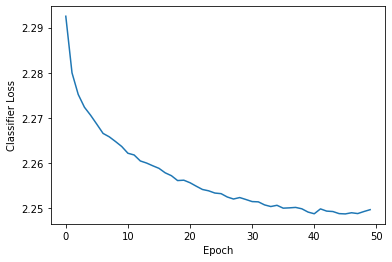

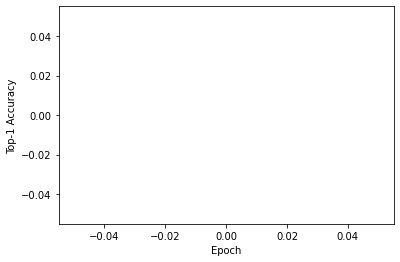

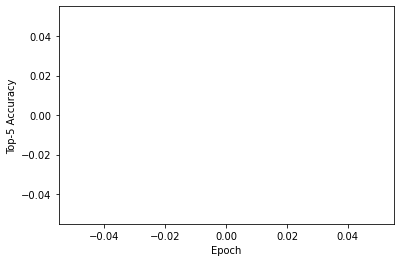

<Figure size 432x288 with 0 Axes>

In [10]:
'''Loading the Classifier Loss logs'''
with open(f"{out_dir}/classifier_loss_logs.pkl",'rb') as f:
    loss = pickle.load(f)
    f.close()
    
from matplotlib import pyplot as plt
plt.plot(loss[1])
# plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.figure()


''' plotting the Top-1 & Top-5 accuracy'''
plt.plot(acc1_hist)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy')
plt.figure()
hist5 = [a.item() for a in acc5_hist]
plt.plot(hist5)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.figure()



In [11]:
from sklearn.mixture import GaussianMixture
import dataloader_cifar as dataloader

def get_train(model, dataloader, estimate_p_right=True, p_right_threshold=0.5, p_clean_threshold=0.5, CBS=True):
    model.eval()
    losses = []
    confidence = []
    label_preds = []
    crit = nn.CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(dataloader):
            inputs, targets = inputs.cuda(), targets.cuda() 
            outputs = model(inputs)
            b_losses = crit(outputs, targets)
            probs, b_preds = torch.max(torch.softmax(outputs, dim=-1), dim=-1)
            confidence.append(probs)
            label_preds.append(b_preds)
            losses.append(b_losses)

    losses = torch.cat(losses, dim=0).cpu()
    confidence = torch.cat(confidence, dim=0).cpu()
    label_preds = torch.cat(label_preds, dim=0).cpu()
    losses = (losses-losses.min())/(losses.max()-losses.min())
    
    input_loss = losses.reshape(-1, 1)
    confidence = confidence.reshape(-1, 1)
    # fit a two-component GMM to the loss
    gmm1 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    gmm1.fit(input_loss)
    prob = gmm1.predict_proba(input_loss)
    p_clean = prob[:,gmm1.means_.argmin()]
    clean = (p_clean > p_clean_threshold)
    if estimate_p_right:
        gmm2 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
        gmm2.fit(confidence)
        print(gmm2.means_)
        prob = gmm2.predict_proba(confidence)
        p_right = prob[:, gmm2.means_.argmax()]
        relabel_indicator = p_right > p_right_threshold
        return loader.run('train', clean, p_clean, CBS=CBS,relabel_indicator=relabel_indicator, label_preds=label_preds)

    return loader.run('train', clean, p_clean, CBS=CBS)


In [12]:
print('remember to change rampup when finished searching for best lambda_u')
def linear_rampup(current, rampup_length=5):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch, lambda_u=75, unsupervised_term=True):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        if unsupervised_term:
            Lu = torch.mean((probs_u - targets_u) ** 2)
            return (Lx, Lu, lambda_u * linear_rampup(epoch))
        return (Lx,)


remember to change rampup when finished searching for best lambda_u


In [13]:
def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [14]:
def kronecker_product(t1, t2):
    """
    Computes the Kronecker product between two tensors.
    See https://en.wikipedia.org/wiki/Kronecker_product
    """
    t1_height, t1_width = t1.shape
    t2_height, t2_width = t2.shape
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

In [15]:
import torch
from torch.nn import ReLU
from torch.nn.functional import normalize

Re = ReLU()
src = torch.ones(32,10)
lab_num = 32# len(L[0])
unlab_num = 64 #len(U)
one_vec1 = torch.ones(lab_num).unsqueeze(dim=0).cuda().detach()
one_vec = torch.ones(unlab_num).unsqueeze(dim=0).cuda().detach()

def graph_structured_regularization(model, L, U, lambda_uu, lambda_lu, tau): #U-unlabled class, L-labled, 
    A_lu = None
    A_uu = None
    with torch.no_grad():
        Z_l = model.encoder(L[0].cuda())
        Z_u = model.encoder(U.cuda())
        Z_l = normalize(Z_l,dim=1)
        Z_u = normalize(Z_u,dim=1)
        A_lu = Re(torch.matmul(Z_l, Z_u.t())-tau)
        A_uu = Re(torch.matmul(Z_u, Z_u.t())-tau)
    y_hat = L[1]
    p = model(U.cuda())
    p = torch.softmax(p, dim=-1)
    # P_mat = kronecker_product(one_vec, p).reshape(unlab_num, unlab_num, 10)
    P_mat = p.repeat(1, unlab_num).view(unlab_num, unlab_num, 10)
    P_mat1 = P_mat[:,:32,:] # kronecker_product(one_vec1, p).reshape(unlab_num, lab_num, 10)
    # Y_mat = kronecker_product(one_vec,y_hat).reshape(lab_num, unlab_num,10)
    Y_mat = y_hat.repeat(1, unlab_num).reshape(lab_num, unlab_num,10)
    P_mat1 = torch.transpose(P_mat1,0,1)
    norm_lu = torch.mean((P_mat1 - Y_mat) **2)
    norm_uu = torch.mean((P_mat - torch.transpose(P_mat,0,1) ** 2))
    return  (0.5 * lambda_uu*A_uu*norm_uu).sum() + (lambda_lu*A_lu*norm_lu).sum() 

In [16]:
import time
from tqdm.notebook  import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F



def train(labeled_trainloader, unlabeled_trainloader, model, criterion, T=0.5, alpha=0.75, train_iteration=1024, graph_reg=True, unsupervised_term=True, epochs=100, exp_name=None, lambda_u=75):
    model.load_state_dict(torch.load(f"cifar10/clf_learning/final_model_wts.bin"))
    acc1_hist = []
    acc5_hist = []
    losses_x_hist = []
    losses_u_hist = []
    losses_r_hist = []
    best_val = 0
    switch_encoder(model, state=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    optimizer.zero_grad()
    print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
    for epoch in range(epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        losses_r = AverageMeter()
        time_loss_r = AverageMeter()

        ws = AverageMeter()
        end = time.time()
        labeled_train_iter = iter(labeled_trainloader)
        unlabeled_train_iter = iter(unlabeled_trainloader)

        model.train()
        for batch_idx in tqdm(range(train_iteration)):
            try:
                inputs_x, targets_x = labeled_train_iter.next()
            except:
                labeled_train_iter = iter(labeled_trainloader)
                inputs_x, targets_x = labeled_train_iter.next()

            try:
                inputs_u, inputs_u2 = unlabeled_train_iter.next()
            except:
                unlabeled_train_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u2 = unlabeled_train_iter.next()

            # measure data loading time
            data_time.update(time.time() - end)

            batch_size = inputs_x.size(0)

            # Transform label to one-hot
            targets_x = torch.zeros(batch_size, 10).scatter_(1, targets_x.view(-1,1).long(), 1)

            inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
            inputs_u = inputs_u.cuda()
            inputs_u2 = inputs_u2.cuda()

            with torch.no_grad():
                # compute guessed labels of unlabel samples
                outputs_u = model(inputs_u)
                outputs_u2 = model(inputs_u2)
                p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
                pt = p ** (1 / T)
                targets_u = pt / pt.sum(dim=1, keepdim=True)
                targets_u = targets_u.detach()

            # mixup
            all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
            all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

            l = np.random.beta(alpha, alpha)

            l = max(l, 1-l)

            idx = torch.randperm(all_inputs.size(0))

            input_a, input_b = all_inputs, all_inputs[idx]
            target_a, target_b = all_targets, all_targets[idx]

            mixed_input = l * input_a + (1 - l) * input_b
            mixed_target = l * target_a + (1 - l) * target_b

            # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
            mixed_input = list(torch.split(mixed_input, batch_size))
            mixed_input = interleave(mixed_input, batch_size)

            logits = [model(mixed_input[0])]
            for input in mixed_input[1:]:
                logits.append(model(input))

            # put interleaved samples back
            logits = interleave(logits, batch_size)
            logits_x = logits[0]
            logits_u = torch.cat(logits[1:], dim=0)

            crit_res = criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration, unsupervised_term=unsupervised_term, lambda_u=lambda_u)
            Lx = crit_res[0]
            loss = Lx
            if unsupervised_term:
                Lu = crit_res[1] 
                w = crit_res[2]
                loss = loss + w * Lu

            if graph_reg:
                R = graph_structured_regularization(model, (inputs_x, targets_x), torch.cat([inputs_u, inputs_u2], dim=0), lambda_uu=0.01, lambda_lu=0.005, tau=0.5)
                loss = loss + R


            # record loss
            losses.update(loss.item(), inputs_x.size(0))
            losses_x.update(Lx.item(), inputs_x.size(0))
            if unsupervised_term:
                losses_u.update(Lu.item(), inputs_x.size(0))
                ws.update(w, inputs_x.size(0))
            if graph_reg:
                losses_r.update(R.item(), inputs_x.size(0))
            

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            if batch_idx % 100 == 0:
                print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | Loss_x: {loss_x:.4f} | Loss_u: {loss_u:.4f} | Loss_R: {loss_r:.4f} | W: {w:.4f}'.format(
                            batch=batch_idx + 1,
                            size=train_iteration,
                            data=data_time.avg,
                            bt=batch_time.avg,
                            loss=losses.avg,
                            loss_x=losses_x.avg,
                            loss_u=losses_u.avg,
                            loss_r=losses_r.avg,
                            w=ws.avg,
                            ))
                losses_x_hist.append(losses_x.avg)
                if unsupervised_term:
                    losses_u_hist.append(losses_u.avg)
                if graph_reg:
                    losses_r_hist.append(losses_r.avg)

            if batch_idx % 500 == 0:
                val,val5 = validate(model, val_dataloader)
                acc1_hist.append(val)
                acc5_hist.append(val5)
                
                if val > best_val:
                    best_val = val
                    best_model_wts = copy.deepcopy(model.state_dict())
            

    torch.save({'losses_x_hist': losses_x_hist, 'losses_u_hist': losses_u_hist, 'losses_r_hist': losses_r_hist, 'best_model_wts': best_model_wts, 'best_val': best_val, 'acc1_hist': acc1_hist, 'acc5_hist': acc5_hist}, f"runs/{exp_name}.bin")



In [17]:

from matplotlib import pyplot as plt
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def plot_result(result):
    fig, axs = plt.subplots(2,2, figsize=(25, 10))
    def get_avg_x_axs(hist):
        if len(hist) == 0:
            return [], []
        values = map(lambda t:  (t[0]%11 != 0, (((1024 * (t[0]//11)) + (t[0]% 11) * 100)/ 1024), t[1]), enumerate(hist))
        filtered_values = filter(lambda t: t[0], values)
        return zip(*map(lambda t: (t[1], t[2]), filtered_values))


    acc1_x_axs = list(map(lambda x: ((1024 * (x//3)) + [0, 500, 1000][x%3]) / 1024, range(len(result['acc1_hist']))))
    x,y = get_avg_x_axs(result['losses_x_hist'])
    axs[0,0].plot(x, y)
    axs[0,0].set_title('Lx')
    axs[0,0].set_xlabel('epoch')
    x, y = get_avg_x_axs(result['losses_r_hist'])
    axs[0,1].plot(x, y)
    axs[0,1].set_title('R')
    axs[0,1].set_xlabel('epoch')
    x, y = get_avg_x_axs(result['losses_u_hist'])
    axs[1,0].plot(x, y)
    axs[1,0].set_title('Lu')
    axs[1,0].set_xlabel('epoch')
    axs[1,1].plot(acc1_x_axs, result['acc1_hist'])
    axs[1,1].set_title('Top-1 acc')
    axs[1,1].set_xlabel('epoch')


loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.16949368]
 [0.2516323 ]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

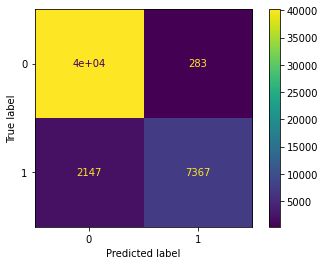

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

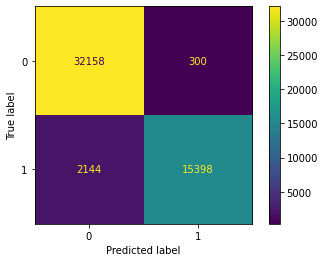

Numer of labeled samples:15698   AUC:0.666

labeled data has a size of 15698
using CBS
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34302
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.25158385]
 [0.16947662]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

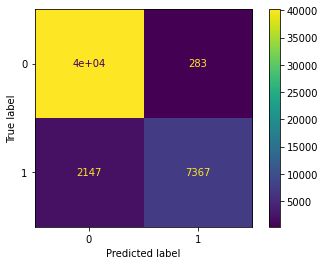

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

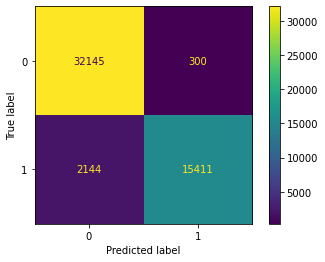

Numer of labeled samples:15711   AUC:0.666

labeled data has a size of 15711
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34289


In [18]:
cbs_labeled_trainloader, cbs_unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=True)
labeled_trainloader, unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=False)

In [19]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name='reproduce')

In [20]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=True, exp_name='no_unsupervised_term')

In [21]:
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=False, exp_name='no_graph_reg')
# plot_result(torch.load('runs/no_graph_reg.bin'))

learnable paramters: 23520842


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.003s | Batch: 1.372s | Loss: 1.9443 | Loss_x: 1.9169 | Loss_u: 0.0000 | Loss_R: 0.0274 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.3, top-5: tensor([98.6900], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.361s | Loss: 1.3775 | Loss_x: 1.2438 | Loss_u: 0.0000 | Loss_R: 0.1337 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 1.2654 | Loss_x: 1.1338 | Loss_u: 0.0000 | Loss_R: 0.1316 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 1.2276 | Loss_x: 1.0982 | Loss_u: 0.0000 | Loss_R: 0.1294 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.314s | Loss: 1.2095 | Loss_x: 1.0823 | Loss_u: 0.0000 | Loss_R: 0.1272 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.312s | Loss: 1.2005 | Loss_x: 1.0733 | Loss_u: 0.0000 | Loss_R: 0.1272 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 82.72, top-5: tensor([98.0900], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 1.1995 | Loss_x: 1.0737 | Loss_u: 0.0000 | Loss_R: 0.1258 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.316s | Loss: 1.2050 | Loss_x: 1.0795 | Loss_u: 0.0000 | Loss_R: 0.1255 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.313s | Loss: 1.2012 | Loss_x: 1.0765 | Loss_u: 0.0000 | Loss_R: 0.1247 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.312s | Loss: 1.1969 | Loss_x: 1.0721 | Loss_u: 0.0000 | Loss_R: 0.1248 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 1.1947 | Loss_x: 1.0696 | Loss_u: 0.0000 | Loss_R: 0.1252 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 82.17, top-5: tensor([97.9400], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.137s | Batch: 1.444s | Loss: 1.7340 | Loss_x: 1.6881 | Loss_u: 0.0000 | Loss_R: 0.0460 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.27, top-5: tensor([97.8100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.358s | Loss: 1.1535 | Loss_x: 1.0531 | Loss_u: 0.0000 | Loss_R: 0.1003 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.330s | Loss: 1.1280 | Loss_x: 1.0202 | Loss_u: 0.0000 | Loss_R: 0.1078 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 1.1210 | Loss_x: 1.0114 | Loss_u: 0.0000 | Loss_R: 0.1096 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 1.1198 | Loss_x: 1.0098 | Loss_u: 0.0000 | Loss_R: 0.1100 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 1.1343 | Loss_x: 1.0231 | Loss_u: 0.0000 | Loss_R: 0.1111 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 83.21, top-5: tensor([97.2000], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 1.1371 | Loss_x: 1.0258 | Loss_u: 0.0000 | Loss_R: 0.1113 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.316s | Loss: 1.1268 | Loss_x: 1.0162 | Loss_u: 0.0000 | Loss_R: 0.1106 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.313s | Loss: 1.1258 | Loss_x: 1.0154 | Loss_u: 0.0000 | Loss_R: 0.1104 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.312s | Loss: 1.1269 | Loss_x: 1.0168 | Loss_u: 0.0000 | Loss_R: 0.1101 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.311s | Loss: 1.1199 | Loss_x: 1.0101 | Loss_u: 0.0000 | Loss_R: 0.1097 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.76, top-5: tensor([98.3200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.224s | Batch: 1.533s | Loss: 1.2991 | Loss_x: 1.2352 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.2, top-5: tensor([98.8100], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.365s | Loss: 1.1493 | Loss_x: 1.0407 | Loss_u: 0.0000 | Loss_R: 0.1086 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 1.1064 | Loss_x: 0.9988 | Loss_u: 0.0000 | Loss_R: 0.1075 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.320s | Loss: 1.0864 | Loss_x: 0.9778 | Loss_u: 0.0000 | Loss_R: 0.1086 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 1.0923 | Loss_x: 0.9840 | Loss_u: 0.0000 | Loss_R: 0.1083 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 1.0973 | Loss_x: 0.9901 | Loss_u: 0.0000 | Loss_R: 0.1072 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.25, top-5: tensor([98.4700], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.319s | Loss: 1.0916 | Loss_x: 0.9845 | Loss_u: 0.0000 | Loss_R: 0.1071 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.316s | Loss: 1.1025 | Loss_x: 0.9952 | Loss_u: 0.0000 | Loss_R: 0.1073 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 1.0966 | Loss_x: 0.9900 | Loss_u: 0.0000 | Loss_R: 0.1066 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.312s | Loss: 1.0975 | Loss_x: 0.9919 | Loss_u: 0.0000 | Loss_R: 0.1056 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.311s | Loss: 1.0949 | Loss_x: 0.9900 | Loss_u: 0.0000 | Loss_R: 0.1049 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 77.72, top-5: tensor([96.0700], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.232s | Batch: 1.540s | Loss: 1.5726 | Loss_x: 1.5027 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.96, top-5: tensor([98.5000], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.364s | Loss: 1.0398 | Loss_x: 0.9452 | Loss_u: 0.0000 | Loss_R: 0.0945 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 1.0675 | Loss_x: 0.9682 | Loss_u: 0.0000 | Loss_R: 0.0993 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 1.0578 | Loss_x: 0.9594 | Loss_u: 0.0000 | Loss_R: 0.0984 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.314s | Loss: 1.0670 | Loss_x: 0.9674 | Loss_u: 0.0000 | Loss_R: 0.0996 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.312s | Loss: 1.0788 | Loss_x: 0.9784 | Loss_u: 0.0000 | Loss_R: 0.1005 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.2, top-5: tensor([98.6400], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 1.0828 | Loss_x: 0.9833 | Loss_u: 0.0000 | Loss_R: 0.0995 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.316s | Loss: 1.0847 | Loss_x: 0.9862 | Loss_u: 0.0000 | Loss_R: 0.0985 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 1.0812 | Loss_x: 0.9830 | Loss_u: 0.0000 | Loss_R: 0.0982 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.312s | Loss: 1.0770 | Loss_x: 0.9785 | Loss_u: 0.0000 | Loss_R: 0.0985 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 1.0751 | Loss_x: 0.9768 | Loss_u: 0.0000 | Loss_R: 0.0983 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.49, top-5: tensor([98.0600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.162s | Batch: 1.471s | Loss: 0.9993 | Loss_x: 0.9167 | Loss_u: 0.0000 | Loss_R: 0.0825 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.2, top-5: tensor([98.1500], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.361s | Loss: 1.0324 | Loss_x: 0.9295 | Loss_u: 0.0000 | Loss_R: 0.1028 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 1.0467 | Loss_x: 0.9455 | Loss_u: 0.0000 | Loss_R: 0.1012 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.319s | Loss: 1.0406 | Loss_x: 0.9419 | Loss_u: 0.0000 | Loss_R: 0.0987 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.314s | Loss: 1.0285 | Loss_x: 0.9309 | Loss_u: 0.0000 | Loss_R: 0.0975 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.312s | Loss: 1.0221 | Loss_x: 0.9246 | Loss_u: 0.0000 | Loss_R: 0.0975 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.76, top-5: tensor([98.2500], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 1.0205 | Loss_x: 0.9230 | Loss_u: 0.0000 | Loss_R: 0.0975 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.315s | Loss: 1.0225 | Loss_x: 0.9254 | Loss_u: 0.0000 | Loss_R: 0.0971 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.313s | Loss: 1.0346 | Loss_x: 0.9377 | Loss_u: 0.0000 | Loss_R: 0.0969 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.312s | Loss: 1.0391 | Loss_x: 0.9429 | Loss_u: 0.0000 | Loss_R: 0.0962 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.311s | Loss: 1.0423 | Loss_x: 0.9463 | Loss_u: 0.0000 | Loss_R: 0.0960 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.69, top-5: tensor([98.], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.250s | Batch: 1.560s | Loss: 0.7981 | Loss_x: 0.7176 | Loss_u: 0.0000 | Loss_R: 0.0805 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.04, top-5: tensor([98.6600], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.361s | Loss: 1.0268 | Loss_x: 0.9255 | Loss_u: 0.0000 | Loss_R: 0.1013 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 1.0223 | Loss_x: 0.9228 | Loss_u: 0.0000 | Loss_R: 0.0995 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.319s | Loss: 1.0311 | Loss_x: 0.9330 | Loss_u: 0.0000 | Loss_R: 0.0980 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 1.0310 | Loss_x: 0.9336 | Loss_u: 0.0000 | Loss_R: 0.0974 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.313s | Loss: 1.0224 | Loss_x: 0.9265 | Loss_u: 0.0000 | Loss_R: 0.0959 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.66, top-5: tensor([97.7700], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 1.0132 | Loss_x: 0.9181 | Loss_u: 0.0000 | Loss_R: 0.0951 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.317s | Loss: 1.0099 | Loss_x: 0.9155 | Loss_u: 0.0000 | Loss_R: 0.0944 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.315s | Loss: 1.0108 | Loss_x: 0.9169 | Loss_u: 0.0000 | Loss_R: 0.0939 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 1.0076 | Loss_x: 0.9144 | Loss_u: 0.0000 | Loss_R: 0.0932 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 1.0051 | Loss_x: 0.9120 | Loss_u: 0.0000 | Loss_R: 0.0931 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.48, top-5: tensor([98.4000], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.200s | Batch: 1.509s | Loss: 1.4056 | Loss_x: 1.3174 | Loss_u: 0.0000 | Loss_R: 0.0881 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.25, top-5: tensor([98.4600], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 1.0201 | Loss_x: 0.9258 | Loss_u: 0.0000 | Loss_R: 0.0943 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.330s | Loss: 1.0375 | Loss_x: 0.9437 | Loss_u: 0.0000 | Loss_R: 0.0938 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.319s | Loss: 1.0216 | Loss_x: 0.9295 | Loss_u: 0.0000 | Loss_R: 0.0920 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.314s | Loss: 1.0183 | Loss_x: 0.9275 | Loss_u: 0.0000 | Loss_R: 0.0909 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.312s | Loss: 1.0120 | Loss_x: 0.9216 | Loss_u: 0.0000 | Loss_R: 0.0904 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 82.97, top-5: tensor([97.9400], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 1.0016 | Loss_x: 0.9119 | Loss_u: 0.0000 | Loss_R: 0.0897 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.315s | Loss: 0.9915 | Loss_x: 0.9025 | Loss_u: 0.0000 | Loss_R: 0.0891 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.9902 | Loss_x: 0.9020 | Loss_u: 0.0000 | Loss_R: 0.0882 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.9880 | Loss_x: 0.9003 | Loss_u: 0.0000 | Loss_R: 0.0877 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.9956 | Loss_x: 0.9083 | Loss_u: 0.0000 | Loss_R: 0.0873 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.05, top-5: tensor([98.3200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.249s | Batch: 1.557s | Loss: 1.2621 | Loss_x: 1.1711 | Loss_u: 0.0000 | Loss_R: 0.0909 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.72, top-5: tensor([98.9200], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.364s | Loss: 1.0162 | Loss_x: 0.9227 | Loss_u: 0.0000 | Loss_R: 0.0934 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.330s | Loss: 0.9888 | Loss_x: 0.8978 | Loss_u: 0.0000 | Loss_R: 0.0909 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.320s | Loss: 0.9845 | Loss_x: 0.8942 | Loss_u: 0.0000 | Loss_R: 0.0904 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9900 | Loss_x: 0.9003 | Loss_u: 0.0000 | Loss_R: 0.0897 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9966 | Loss_x: 0.9080 | Loss_u: 0.0000 | Loss_R: 0.0887 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.57, top-5: tensor([98.6500], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.9944 | Loss_x: 0.9067 | Loss_u: 0.0000 | Loss_R: 0.0878 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.9853 | Loss_x: 0.8986 | Loss_u: 0.0000 | Loss_R: 0.0867 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.9824 | Loss_x: 0.8961 | Loss_u: 0.0000 | Loss_R: 0.0863 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9722 | Loss_x: 0.8865 | Loss_u: 0.0000 | Loss_R: 0.0857 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.9784 | Loss_x: 0.8935 | Loss_u: 0.0000 | Loss_R: 0.0849 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.48, top-5: tensor([98.5600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.247s | Batch: 1.559s | Loss: 0.7787 | Loss_x: 0.6902 | Loss_u: 0.0000 | Loss_R: 0.0885 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.78, top-5: tensor([98.7800], device='cuda:0')
(101/1024) Data: 0.074s | Batch: 0.367s | Loss: 0.9987 | Loss_x: 0.9082 | Loss_u: 0.0000 | Loss_R: 0.0905 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.334s | Loss: 0.9692 | Loss_x: 0.8787 | Loss_u: 0.0000 | Loss_R: 0.0905 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.323s | Loss: 0.9730 | Loss_x: 0.8830 | Loss_u: 0.0000 | Loss_R: 0.0900 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.9739 | Loss_x: 0.8845 | Loss_u: 0.0000 | Loss_R: 0.0894 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.9672 | Loss_x: 0.8784 | Loss_u: 0.0000 | Loss_R: 0.0889 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.64, top-5: tensor([97.8600], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.9719 | Loss_x: 0.8847 | Loss_u: 0.0000 | Loss_R: 0.0871 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.9780 | Loss_x: 0.8916 | Loss_u: 0.0000 | Loss_R: 0.0864 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9749 | Loss_x: 0.8896 | Loss_u: 0.0000 | Loss_R: 0.0853 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9687 | Loss_x: 0.8839 | Loss_u: 0.0000 | Loss_R: 0.0848 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.9684 | Loss_x: 0.8836 | Loss_u: 0.0000 | Loss_R: 0.0848 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.05, top-5: tensor([97.2600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.223s | Batch: 1.532s | Loss: 1.7488 | Loss_x: 1.6614 | Loss_u: 0.0000 | Loss_R: 0.0874 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.17, top-5: tensor([98.7900], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.362s | Loss: 0.9407 | Loss_x: 0.8516 | Loss_u: 0.0000 | Loss_R: 0.0892 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.332s | Loss: 0.9600 | Loss_x: 0.8730 | Loss_u: 0.0000 | Loss_R: 0.0869 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.9496 | Loss_x: 0.8635 | Loss_u: 0.0000 | Loss_R: 0.0861 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.9527 | Loss_x: 0.8683 | Loss_u: 0.0000 | Loss_R: 0.0844 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9677 | Loss_x: 0.8835 | Loss_u: 0.0000 | Loss_R: 0.0842 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.02, top-5: tensor([97.9100], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.320s | Loss: 0.9648 | Loss_x: 0.8814 | Loss_u: 0.0000 | Loss_R: 0.0834 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.9640 | Loss_x: 0.8811 | Loss_u: 0.0000 | Loss_R: 0.0828 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.9614 | Loss_x: 0.8787 | Loss_u: 0.0000 | Loss_R: 0.0827 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9629 | Loss_x: 0.8808 | Loss_u: 0.0000 | Loss_R: 0.0821 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.9588 | Loss_x: 0.8772 | Loss_u: 0.0000 | Loss_R: 0.0817 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.45, top-5: tensor([98.8200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.279s | Batch: 1.591s | Loss: 0.6052 | Loss_x: 0.5141 | Loss_u: 0.0000 | Loss_R: 0.0910 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.01, top-5: tensor([99.0800], device='cuda:0')
(101/1024) Data: 0.074s | Batch: 0.366s | Loss: 0.8890 | Loss_x: 0.8017 | Loss_u: 0.0000 | Loss_R: 0.0874 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.333s | Loss: 0.9563 | Loss_x: 0.8697 | Loss_u: 0.0000 | Loss_R: 0.0866 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.9864 | Loss_x: 0.9016 | Loss_u: 0.0000 | Loss_R: 0.0848 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.9848 | Loss_x: 0.9007 | Loss_u: 0.0000 | Loss_R: 0.0841 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.9822 | Loss_x: 0.8994 | Loss_u: 0.0000 | Loss_R: 0.0828 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.6, top-5: tensor([98.0300], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.9729 | Loss_x: 0.8908 | Loss_u: 0.0000 | Loss_R: 0.0820 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.9704 | Loss_x: 0.8886 | Loss_u: 0.0000 | Loss_R: 0.0818 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.9702 | Loss_x: 0.8894 | Loss_u: 0.0000 | Loss_R: 0.0808 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9613 | Loss_x: 0.8807 | Loss_u: 0.0000 | Loss_R: 0.0806 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.9653 | Loss_x: 0.8852 | Loss_u: 0.0000 | Loss_R: 0.0801 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.46, top-5: tensor([97.7000], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.230s | Batch: 1.548s | Loss: 1.4920 | Loss_x: 1.4012 | Loss_u: 0.0000 | Loss_R: 0.0908 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.77, top-5: tensor([98.7100], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 0.9612 | Loss_x: 0.8771 | Loss_u: 0.0000 | Loss_R: 0.0841 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.330s | Loss: 0.9466 | Loss_x: 0.8626 | Loss_u: 0.0000 | Loss_R: 0.0839 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.9609 | Loss_x: 0.8783 | Loss_u: 0.0000 | Loss_R: 0.0826 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9719 | Loss_x: 0.8895 | Loss_u: 0.0000 | Loss_R: 0.0824 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9645 | Loss_x: 0.8826 | Loss_u: 0.0000 | Loss_R: 0.0820 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.87, top-5: tensor([98.8000], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.9595 | Loss_x: 0.8781 | Loss_u: 0.0000 | Loss_R: 0.0814 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.9550 | Loss_x: 0.8736 | Loss_u: 0.0000 | Loss_R: 0.0814 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.9528 | Loss_x: 0.8717 | Loss_u: 0.0000 | Loss_R: 0.0811 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.9465 | Loss_x: 0.8660 | Loss_u: 0.0000 | Loss_R: 0.0805 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.9508 | Loss_x: 0.8709 | Loss_u: 0.0000 | Loss_R: 0.0799 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.88, top-5: tensor([97.7500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.168s | Batch: 1.476s | Loss: 1.4128 | Loss_x: 1.3227 | Loss_u: 0.0000 | Loss_R: 0.0901 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.91, top-5: tensor([98.4700], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 0.9735 | Loss_x: 0.8906 | Loss_u: 0.0000 | Loss_R: 0.0829 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.332s | Loss: 0.8999 | Loss_x: 0.8166 | Loss_u: 0.0000 | Loss_R: 0.0833 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.9292 | Loss_x: 0.8465 | Loss_u: 0.0000 | Loss_R: 0.0827 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.9458 | Loss_x: 0.8638 | Loss_u: 0.0000 | Loss_R: 0.0820 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9358 | Loss_x: 0.8544 | Loss_u: 0.0000 | Loss_R: 0.0815 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.83, top-5: tensor([98.7500], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.9413 | Loss_x: 0.8607 | Loss_u: 0.0000 | Loss_R: 0.0806 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.9341 | Loss_x: 0.8544 | Loss_u: 0.0000 | Loss_R: 0.0797 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9346 | Loss_x: 0.8555 | Loss_u: 0.0000 | Loss_R: 0.0791 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9385 | Loss_x: 0.8599 | Loss_u: 0.0000 | Loss_R: 0.0786 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.9415 | Loss_x: 0.8633 | Loss_u: 0.0000 | Loss_R: 0.0782 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.75, top-5: tensor([98.3100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.205s | Batch: 1.510s | Loss: 1.0135 | Loss_x: 0.9131 | Loss_u: 0.0000 | Loss_R: 0.1004 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.88, top-5: tensor([98.7300], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 0.8599 | Loss_x: 0.7798 | Loss_u: 0.0000 | Loss_R: 0.0801 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.332s | Loss: 0.9044 | Loss_x: 0.8264 | Loss_u: 0.0000 | Loss_R: 0.0780 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.9048 | Loss_x: 0.8269 | Loss_u: 0.0000 | Loss_R: 0.0778 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.9343 | Loss_x: 0.8564 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9362 | Loss_x: 0.8573 | Loss_u: 0.0000 | Loss_R: 0.0789 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 83.49, top-5: tensor([96.1200], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.9379 | Loss_x: 0.8595 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.9368 | Loss_x: 0.8588 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.9357 | Loss_x: 0.8581 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9430 | Loss_x: 0.8656 | Loss_u: 0.0000 | Loss_R: 0.0774 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.9396 | Loss_x: 0.8627 | Loss_u: 0.0000 | Loss_R: 0.0769 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.03, top-5: tensor([98.3500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.208s | Batch: 1.521s | Loss: 0.6643 | Loss_x: 0.5654 | Loss_u: 0.0000 | Loss_R: 0.0989 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.14, top-5: tensor([98.5100], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.361s | Loss: 0.9560 | Loss_x: 0.8764 | Loss_u: 0.0000 | Loss_R: 0.0796 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.9625 | Loss_x: 0.8818 | Loss_u: 0.0000 | Loss_R: 0.0807 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.9553 | Loss_x: 0.8761 | Loss_u: 0.0000 | Loss_R: 0.0792 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.9467 | Loss_x: 0.8678 | Loss_u: 0.0000 | Loss_R: 0.0789 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9456 | Loss_x: 0.8673 | Loss_u: 0.0000 | Loss_R: 0.0783 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.7, top-5: tensor([98.4700], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.9422 | Loss_x: 0.8643 | Loss_u: 0.0000 | Loss_R: 0.0779 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.9339 | Loss_x: 0.8565 | Loss_u: 0.0000 | Loss_R: 0.0774 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.9385 | Loss_x: 0.8616 | Loss_u: 0.0000 | Loss_R: 0.0769 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.9384 | Loss_x: 0.8619 | Loss_u: 0.0000 | Loss_R: 0.0765 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.9356 | Loss_x: 0.8595 | Loss_u: 0.0000 | Loss_R: 0.0761 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.67, top-5: tensor([98.4900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.228s | Batch: 1.532s | Loss: 0.6305 | Loss_x: 0.5318 | Loss_u: 0.0000 | Loss_R: 0.0987 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.88, top-5: tensor([98.6600], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.362s | Loss: 0.8394 | Loss_x: 0.7626 | Loss_u: 0.0000 | Loss_R: 0.0768 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.8609 | Loss_x: 0.7846 | Loss_u: 0.0000 | Loss_R: 0.0763 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8819 | Loss_x: 0.8055 | Loss_u: 0.0000 | Loss_R: 0.0765 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8920 | Loss_x: 0.8159 | Loss_u: 0.0000 | Loss_R: 0.0761 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8895 | Loss_x: 0.8138 | Loss_u: 0.0000 | Loss_R: 0.0757 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.54, top-5: tensor([97.9100], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8849 | Loss_x: 0.8102 | Loss_u: 0.0000 | Loss_R: 0.0748 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8966 | Loss_x: 0.8217 | Loss_u: 0.0000 | Loss_R: 0.0749 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9001 | Loss_x: 0.8253 | Loss_u: 0.0000 | Loss_R: 0.0748 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8990 | Loss_x: 0.8242 | Loss_u: 0.0000 | Loss_R: 0.0747 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8990 | Loss_x: 0.8241 | Loss_u: 0.0000 | Loss_R: 0.0749 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 82.35, top-5: tensor([97.8400], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.205s | Batch: 1.522s | Loss: 0.6709 | Loss_x: 0.5706 | Loss_u: 0.0000 | Loss_R: 0.1003 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.33, top-5: tensor([98.6300], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.361s | Loss: 0.9651 | Loss_x: 0.8876 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.9496 | Loss_x: 0.8718 | Loss_u: 0.0000 | Loss_R: 0.0778 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.9652 | Loss_x: 0.8876 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.9485 | Loss_x: 0.8719 | Loss_u: 0.0000 | Loss_R: 0.0765 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9389 | Loss_x: 0.8627 | Loss_u: 0.0000 | Loss_R: 0.0763 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.35, top-5: tensor([97.6300], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.9395 | Loss_x: 0.8636 | Loss_u: 0.0000 | Loss_R: 0.0759 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.9430 | Loss_x: 0.8675 | Loss_u: 0.0000 | Loss_R: 0.0755 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.9339 | Loss_x: 0.8590 | Loss_u: 0.0000 | Loss_R: 0.0749 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9333 | Loss_x: 0.8590 | Loss_u: 0.0000 | Loss_R: 0.0743 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.9278 | Loss_x: 0.8539 | Loss_u: 0.0000 | Loss_R: 0.0739 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.9, top-5: tensor([98.9800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.233s | Batch: 1.541s | Loss: 1.4558 | Loss_x: 1.3548 | Loss_u: 0.0000 | Loss_R: 0.1009 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.55, top-5: tensor([98.9700], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.362s | Loss: 0.8778 | Loss_x: 0.8017 | Loss_u: 0.0000 | Loss_R: 0.0762 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.9291 | Loss_x: 0.8526 | Loss_u: 0.0000 | Loss_R: 0.0765 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.9402 | Loss_x: 0.8639 | Loss_u: 0.0000 | Loss_R: 0.0763 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9334 | Loss_x: 0.8572 | Loss_u: 0.0000 | Loss_R: 0.0762 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.9350 | Loss_x: 0.8583 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.46, top-5: tensor([98.0800], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.320s | Loss: 0.9152 | Loss_x: 0.8392 | Loss_u: 0.0000 | Loss_R: 0.0760 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.9199 | Loss_x: 0.8443 | Loss_u: 0.0000 | Loss_R: 0.0756 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.9128 | Loss_x: 0.8378 | Loss_u: 0.0000 | Loss_R: 0.0750 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9119 | Loss_x: 0.8373 | Loss_u: 0.0000 | Loss_R: 0.0746 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.9147 | Loss_x: 0.8404 | Loss_u: 0.0000 | Loss_R: 0.0742 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.45, top-5: tensor([97.7200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.246s | Batch: 1.555s | Loss: 1.4322 | Loss_x: 1.3216 | Loss_u: 0.0000 | Loss_R: 0.1107 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.26, top-5: tensor([98.8200], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.365s | Loss: 0.9135 | Loss_x: 0.8378 | Loss_u: 0.0000 | Loss_R: 0.0757 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.9270 | Loss_x: 0.8525 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.9273 | Loss_x: 0.8528 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9272 | Loss_x: 0.8529 | Loss_u: 0.0000 | Loss_R: 0.0744 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9258 | Loss_x: 0.8522 | Loss_u: 0.0000 | Loss_R: 0.0736 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 84.9, top-5: tensor([98.3600], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.320s | Loss: 0.9284 | Loss_x: 0.8551 | Loss_u: 0.0000 | Loss_R: 0.0733 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.9269 | Loss_x: 0.8543 | Loss_u: 0.0000 | Loss_R: 0.0726 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.9264 | Loss_x: 0.8545 | Loss_u: 0.0000 | Loss_R: 0.0719 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9262 | Loss_x: 0.8545 | Loss_u: 0.0000 | Loss_R: 0.0717 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.9248 | Loss_x: 0.8531 | Loss_u: 0.0000 | Loss_R: 0.0717 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.33, top-5: tensor([98.3800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.224s | Batch: 1.556s | Loss: 0.7835 | Loss_x: 0.6723 | Loss_u: 0.0000 | Loss_R: 0.1111 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.94, top-5: tensor([98.7800], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.363s | Loss: 0.8572 | Loss_x: 0.7819 | Loss_u: 0.0000 | Loss_R: 0.0753 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.8738 | Loss_x: 0.8002 | Loss_u: 0.0000 | Loss_R: 0.0736 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8977 | Loss_x: 0.8245 | Loss_u: 0.0000 | Loss_R: 0.0733 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.9021 | Loss_x: 0.8296 | Loss_u: 0.0000 | Loss_R: 0.0726 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.9022 | Loss_x: 0.8297 | Loss_u: 0.0000 | Loss_R: 0.0725 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.25, top-5: tensor([98.8000], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.320s | Loss: 0.9004 | Loss_x: 0.8280 | Loss_u: 0.0000 | Loss_R: 0.0725 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8882 | Loss_x: 0.8160 | Loss_u: 0.0000 | Loss_R: 0.0722 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8865 | Loss_x: 0.8147 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8915 | Loss_x: 0.8199 | Loss_u: 0.0000 | Loss_R: 0.0716 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8893 | Loss_x: 0.8179 | Loss_u: 0.0000 | Loss_R: 0.0714 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.08, top-5: tensor([97.6700], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.238s | Batch: 1.548s | Loss: 1.3148 | Loss_x: 1.1929 | Loss_u: 0.0000 | Loss_R: 0.1219 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.91, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.363s | Loss: 0.9109 | Loss_x: 0.8386 | Loss_u: 0.0000 | Loss_R: 0.0722 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.331s | Loss: 0.9090 | Loss_x: 0.8368 | Loss_u: 0.0000 | Loss_R: 0.0722 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8909 | Loss_x: 0.8187 | Loss_u: 0.0000 | Loss_R: 0.0721 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8870 | Loss_x: 0.8146 | Loss_u: 0.0000 | Loss_R: 0.0724 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8963 | Loss_x: 0.8242 | Loss_u: 0.0000 | Loss_R: 0.0721 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.35, top-5: tensor([98.4000], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8876 | Loss_x: 0.8163 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8843 | Loss_x: 0.8136 | Loss_u: 0.0000 | Loss_R: 0.0708 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8807 | Loss_x: 0.8102 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8878 | Loss_x: 0.8175 | Loss_u: 0.0000 | Loss_R: 0.0703 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8831 | Loss_x: 0.8128 | Loss_u: 0.0000 | Loss_R: 0.0702 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.2, top-5: tensor([98.2500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.215s | Batch: 1.522s | Loss: 0.8437 | Loss_x: 0.7338 | Loss_u: 0.0000 | Loss_R: 0.1099 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.96, top-5: tensor([98.8700], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.366s | Loss: 0.8817 | Loss_x: 0.8069 | Loss_u: 0.0000 | Loss_R: 0.0748 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.333s | Loss: 0.9164 | Loss_x: 0.8425 | Loss_u: 0.0000 | Loss_R: 0.0739 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.322s | Loss: 0.8970 | Loss_x: 0.8232 | Loss_u: 0.0000 | Loss_R: 0.0738 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8866 | Loss_x: 0.8135 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8913 | Loss_x: 0.8184 | Loss_u: 0.0000 | Loss_R: 0.0729 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.86, top-5: tensor([98.4100], device='cuda:0')
(601/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8895 | Loss_x: 0.8170 | Loss_u: 0.0000 | Loss_R: 0.0725 | W: 0.0000
(701/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8939 | Loss_x: 0.8220 | Loss_u: 0.0000 | Loss_R: 0.0719 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8975 | Loss_x: 0.8263 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8870 | Loss_x: 0.8163 | Loss_u: 0.0000 | Loss_R: 0.0707 | W: 0.0000
(1001/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8917 | Loss_x: 0.8213 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.62, top-5: tensor([98.2300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.219s | Batch: 1.528s | Loss: 0.4915 | Loss_x: 0.3738 | Loss_u: 0.0000 | Loss_R: 0.1176 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.06, top-5: tensor([98.3500], device='cuda:0')
(101/1024) Data: 0.074s | Batch: 0.367s | Loss: 0.9736 | Loss_x: 0.9022 | Loss_u: 0.0000 | Loss_R: 0.0715 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.333s | Loss: 0.9505 | Loss_x: 0.8788 | Loss_u: 0.0000 | Loss_R: 0.0717 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.322s | Loss: 0.9518 | Loss_x: 0.8805 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.9287 | Loss_x: 0.8576 | Loss_u: 0.0000 | Loss_R: 0.0711 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.9120 | Loss_x: 0.8409 | Loss_u: 0.0000 | Loss_R: 0.0711 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.7, top-5: tensor([98.4900], device='cuda:0')
(601/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.9106 | Loss_x: 0.8400 | Loss_u: 0.0000 | Loss_R: 0.0705 | W: 0.0000
(701/1024) Data: 0.026s | Batch: 0.319s | Loss: 0.9043 | Loss_x: 0.8341 | Loss_u: 0.0000 | Loss_R: 0.0701 | W: 0.0000
(801/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8971 | Loss_x: 0.8271 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(901/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8933 | Loss_x: 0.8236 | Loss_u: 0.0000 | Loss_R: 0.0698 | W: 0.0000
(1001/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8916 | Loss_x: 0.8220 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.74, top-5: tensor([98.7000], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.159s | Batch: 1.464s | Loss: 1.4718 | Loss_x: 1.3599 | Loss_u: 0.0000 | Loss_R: 0.1120 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.4, top-5: tensor([98.8200], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.365s | Loss: 0.8390 | Loss_x: 0.7679 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.333s | Loss: 0.8631 | Loss_x: 0.7909 | Loss_u: 0.0000 | Loss_R: 0.0722 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.322s | Loss: 0.8577 | Loss_x: 0.7864 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8660 | Loss_x: 0.7950 | Loss_u: 0.0000 | Loss_R: 0.0710 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8792 | Loss_x: 0.8087 | Loss_u: 0.0000 | Loss_R: 0.0705 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.49, top-5: tensor([98.2400], device='cuda:0')
(601/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8722 | Loss_x: 0.8020 | Loss_u: 0.0000 | Loss_R: 0.0702 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8754 | Loss_x: 0.8053 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8825 | Loss_x: 0.8129 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8866 | Loss_x: 0.8172 | Loss_u: 0.0000 | Loss_R: 0.0695 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8906 | Loss_x: 0.8211 | Loss_u: 0.0000 | Loss_R: 0.0695 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.73, top-5: tensor([97.6600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.235s | Batch: 1.540s | Loss: 0.7126 | Loss_x: 0.6006 | Loss_u: 0.0000 | Loss_R: 0.1120 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.68, top-5: tensor([98.4200], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.367s | Loss: 0.8768 | Loss_x: 0.8068 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.332s | Loss: 0.8741 | Loss_x: 0.8041 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.320s | Loss: 0.8918 | Loss_x: 0.8209 | Loss_u: 0.0000 | Loss_R: 0.0710 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8824 | Loss_x: 0.8114 | Loss_u: 0.0000 | Loss_R: 0.0709 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8821 | Loss_x: 0.8111 | Loss_u: 0.0000 | Loss_R: 0.0710 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.33, top-5: tensor([98.1000], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8823 | Loss_x: 0.8116 | Loss_u: 0.0000 | Loss_R: 0.0707 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8748 | Loss_x: 0.8043 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8771 | Loss_x: 0.8072 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8851 | Loss_x: 0.8154 | Loss_u: 0.0000 | Loss_R: 0.0697 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8830 | Loss_x: 0.8137 | Loss_u: 0.0000 | Loss_R: 0.0693 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.61, top-5: tensor([98.9100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.256s | Batch: 1.568s | Loss: 0.5384 | Loss_x: 0.4243 | Loss_u: 0.0000 | Loss_R: 0.1140 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.22, top-5: tensor([98.7100], device='cuda:0')
(101/1024) Data: 0.076s | Batch: 0.368s | Loss: 0.9120 | Loss_x: 0.8416 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(201/1024) Data: 0.042s | Batch: 0.335s | Loss: 0.9062 | Loss_x: 0.8344 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000
(301/1024) Data: 0.031s | Batch: 0.323s | Loss: 0.9141 | Loss_x: 0.8438 | Loss_u: 0.0000 | Loss_R: 0.0703 | W: 0.0000
(401/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8911 | Loss_x: 0.8209 | Loss_u: 0.0000 | Loss_R: 0.0703 | W: 0.0000
(501/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8858 | Loss_x: 0.8157 | Loss_u: 0.0000 | Loss_R: 0.0701 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.27, top-5: tensor([97.5100], device='cuda:0')
(601/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8736 | Loss_x: 0.8036 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000
(701/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8647 | Loss_x: 0.7951 | Loss_u: 0.0000 | Loss_R: 0.0697 | W: 0.0000
(801/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8661 | Loss_x: 0.7963 | Loss_u: 0.0000 | Loss_R: 0.0698 | W: 0.0000
(901/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8644 | Loss_x: 0.7948 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000
(1001/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8655 | Loss_x: 0.7961 | Loss_u: 0.0000 | Loss_R: 0.0694 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.66, top-5: tensor([98.3800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.268s | Batch: 1.606s | Loss: 0.8424 | Loss_x: 0.7221 | Loss_u: 0.0000 | Loss_R: 0.1203 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.47, top-5: tensor([98.6100], device='cuda:0')
(101/1024) Data: 0.075s | Batch: 0.367s | Loss: 0.8474 | Loss_x: 0.7777 | Loss_u: 0.0000 | Loss_R: 0.0697 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.334s | Loss: 0.8138 | Loss_x: 0.7444 | Loss_u: 0.0000 | Loss_R: 0.0693 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.322s | Loss: 0.8295 | Loss_x: 0.7603 | Loss_u: 0.0000 | Loss_R: 0.0692 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8411 | Loss_x: 0.7722 | Loss_u: 0.0000 | Loss_R: 0.0689 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8517 | Loss_x: 0.7831 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.92, top-5: tensor([98.5400], device='cuda:0')
(601/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.8528 | Loss_x: 0.7840 | Loss_u: 0.0000 | Loss_R: 0.0689 | W: 0.0000
(701/1024) Data: 0.026s | Batch: 0.319s | Loss: 0.8485 | Loss_x: 0.7797 | Loss_u: 0.0000 | Loss_R: 0.0688 | W: 0.0000
(801/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8522 | Loss_x: 0.7834 | Loss_u: 0.0000 | Loss_R: 0.0688 | W: 0.0000
(901/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8584 | Loss_x: 0.7899 | Loss_u: 0.0000 | Loss_R: 0.0685 | W: 0.0000
(1001/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8553 | Loss_x: 0.7871 | Loss_u: 0.0000 | Loss_R: 0.0681 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.47, top-5: tensor([98.7500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.208s | Batch: 1.528s | Loss: 1.3157 | Loss_x: 1.1885 | Loss_u: 0.0000 | Loss_R: 0.1273 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.0, top-5: tensor([98.4700], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.362s | Loss: 0.8643 | Loss_x: 0.7946 | Loss_u: 0.0000 | Loss_R: 0.0697 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.331s | Loss: 0.8516 | Loss_x: 0.7828 | Loss_u: 0.0000 | Loss_R: 0.0689 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8492 | Loss_x: 0.7807 | Loss_u: 0.0000 | Loss_R: 0.0685 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8652 | Loss_x: 0.7972 | Loss_u: 0.0000 | Loss_R: 0.0681 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8567 | Loss_x: 0.7888 | Loss_u: 0.0000 | Loss_R: 0.0679 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.7, top-5: tensor([97.2600], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.8657 | Loss_x: 0.7975 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8706 | Loss_x: 0.8023 | Loss_u: 0.0000 | Loss_R: 0.0683 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8750 | Loss_x: 0.8068 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8722 | Loss_x: 0.8041 | Loss_u: 0.0000 | Loss_R: 0.0681 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8703 | Loss_x: 0.8024 | Loss_u: 0.0000 | Loss_R: 0.0679 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.96, top-5: tensor([98.4600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.163s | Batch: 1.483s | Loss: 1.5777 | Loss_x: 1.4392 | Loss_u: 0.0000 | Loss_R: 0.1385 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.31, top-5: tensor([99.0500], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.363s | Loss: 0.8008 | Loss_x: 0.7313 | Loss_u: 0.0000 | Loss_R: 0.0695 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.8529 | Loss_x: 0.7854 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8517 | Loss_x: 0.7840 | Loss_u: 0.0000 | Loss_R: 0.0677 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8581 | Loss_x: 0.7908 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8710 | Loss_x: 0.8037 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.14, top-5: tensor([98.3400], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.8734 | Loss_x: 0.8063 | Loss_u: 0.0000 | Loss_R: 0.0671 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8764 | Loss_x: 0.8092 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8707 | Loss_x: 0.8035 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8792 | Loss_x: 0.8116 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8749 | Loss_x: 0.8077 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.5, top-5: tensor([98.0900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.261s | Batch: 1.569s | Loss: 0.5027 | Loss_x: 0.3695 | Loss_u: 0.0000 | Loss_R: 0.1332 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.98, top-5: tensor([98.5900], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.367s | Loss: 0.8271 | Loss_x: 0.7582 | Loss_u: 0.0000 | Loss_R: 0.0689 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.334s | Loss: 0.8196 | Loss_x: 0.7515 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.323s | Loss: 0.8221 | Loss_x: 0.7535 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8122 | Loss_x: 0.7432 | Loss_u: 0.0000 | Loss_R: 0.0691 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.315s | Loss: 0.8151 | Loss_x: 0.7461 | Loss_u: 0.0000 | Loss_R: 0.0690 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.03, top-5: tensor([98.9000], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8198 | Loss_x: 0.7514 | Loss_u: 0.0000 | Loss_R: 0.0685 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8225 | Loss_x: 0.7539 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8243 | Loss_x: 0.7562 | Loss_u: 0.0000 | Loss_R: 0.0681 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8296 | Loss_x: 0.7619 | Loss_u: 0.0000 | Loss_R: 0.0677 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8384 | Loss_x: 0.7711 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.08, top-5: tensor([98.8400], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.255s | Batch: 1.560s | Loss: 1.6709 | Loss_x: 1.5396 | Loss_u: 0.0000 | Loss_R: 0.1313 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.48, top-5: tensor([98.9700], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.364s | Loss: 0.8355 | Loss_x: 0.7643 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.333s | Loss: 0.8645 | Loss_x: 0.7943 | Loss_u: 0.0000 | Loss_R: 0.0702 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.8651 | Loss_x: 0.7960 | Loss_u: 0.0000 | Loss_R: 0.0691 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8704 | Loss_x: 0.8022 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8731 | Loss_x: 0.8056 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.54, top-5: tensor([98.6800], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8669 | Loss_x: 0.7997 | Loss_u: 0.0000 | Loss_R: 0.0671 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8727 | Loss_x: 0.8057 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8663 | Loss_x: 0.7993 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8600 | Loss_x: 0.7930 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8577 | Loss_x: 0.7909 | Loss_u: 0.0000 | Loss_R: 0.0667 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.35, top-5: tensor([98.3900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.246s | Batch: 1.559s | Loss: 1.4189 | Loss_x: 1.2992 | Loss_u: 0.0000 | Loss_R: 0.1197 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.81, top-5: tensor([98.7500], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.365s | Loss: 0.8232 | Loss_x: 0.7556 | Loss_u: 0.0000 | Loss_R: 0.0676 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.8544 | Loss_x: 0.7874 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8735 | Loss_x: 0.8074 | Loss_u: 0.0000 | Loss_R: 0.0661 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8780 | Loss_x: 0.8119 | Loss_u: 0.0000 | Loss_R: 0.0661 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8734 | Loss_x: 0.8073 | Loss_u: 0.0000 | Loss_R: 0.0661 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.5, top-5: tensor([97.9700], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.320s | Loss: 0.8777 | Loss_x: 0.8119 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8715 | Loss_x: 0.8058 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8705 | Loss_x: 0.8049 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8736 | Loss_x: 0.8082 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8720 | Loss_x: 0.8067 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.37, top-5: tensor([98.2300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.223s | Batch: 1.533s | Loss: 0.7062 | Loss_x: 0.5749 | Loss_u: 0.0000 | Loss_R: 0.1313 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.57, top-5: tensor([98.7200], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.365s | Loss: 0.8773 | Loss_x: 0.8087 | Loss_u: 0.0000 | Loss_R: 0.0685 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.333s | Loss: 0.8557 | Loss_x: 0.7887 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.323s | Loss: 0.8645 | Loss_x: 0.7981 | Loss_u: 0.0000 | Loss_R: 0.0663 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8613 | Loss_x: 0.7952 | Loss_u: 0.0000 | Loss_R: 0.0661 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8619 | Loss_x: 0.7960 | Loss_u: 0.0000 | Loss_R: 0.0659 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.27, top-5: tensor([98.0600], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8560 | Loss_x: 0.7901 | Loss_u: 0.0000 | Loss_R: 0.0659 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.319s | Loss: 0.8576 | Loss_x: 0.7920 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8554 | Loss_x: 0.7900 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8517 | Loss_x: 0.7866 | Loss_u: 0.0000 | Loss_R: 0.0651 | W: 0.0000
(1001/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8507 | Loss_x: 0.7859 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.9, top-5: tensor([98.7400], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.223s | Batch: 1.533s | Loss: 1.2962 | Loss_x: 1.1499 | Loss_u: 0.0000 | Loss_R: 0.1463 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.88, top-5: tensor([98.8100], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.364s | Loss: 0.8548 | Loss_x: 0.7890 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.332s | Loss: 0.8547 | Loss_x: 0.7893 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.8430 | Loss_x: 0.7778 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8413 | Loss_x: 0.7760 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8509 | Loss_x: 0.7858 | Loss_u: 0.0000 | Loss_R: 0.0651 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.59, top-5: tensor([98.1300], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8458 | Loss_x: 0.7806 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8426 | Loss_x: 0.7777 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8439 | Loss_x: 0.7793 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8480 | Loss_x: 0.7835 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8549 | Loss_x: 0.7905 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.67, top-5: tensor([98.3800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.202s | Batch: 1.507s | Loss: 1.3823 | Loss_x: 1.2348 | Loss_u: 0.0000 | Loss_R: 0.1475 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.43, top-5: tensor([98.6300], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.362s | Loss: 0.8548 | Loss_x: 0.7900 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.332s | Loss: 0.8440 | Loss_x: 0.7787 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8446 | Loss_x: 0.7799 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8263 | Loss_x: 0.7615 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8384 | Loss_x: 0.7736 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.83, top-5: tensor([98.4500], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8329 | Loss_x: 0.7681 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8404 | Loss_x: 0.7759 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8358 | Loss_x: 0.7711 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8314 | Loss_x: 0.7668 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8388 | Loss_x: 0.7743 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.03, top-5: tensor([98.0100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.239s | Batch: 1.552s | Loss: 1.2812 | Loss_x: 1.1273 | Loss_u: 0.0000 | Loss_R: 0.1538 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.83, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.367s | Loss: 0.8839 | Loss_x: 0.8166 | Loss_u: 0.0000 | Loss_R: 0.0674 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.335s | Loss: 0.8469 | Loss_x: 0.7802 | Loss_u: 0.0000 | Loss_R: 0.0667 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.323s | Loss: 0.8344 | Loss_x: 0.7678 | Loss_u: 0.0000 | Loss_R: 0.0666 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8366 | Loss_x: 0.7706 | Loss_u: 0.0000 | Loss_R: 0.0660 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8358 | Loss_x: 0.7699 | Loss_u: 0.0000 | Loss_R: 0.0659 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.99, top-5: tensor([97.7700], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.322s | Loss: 0.8432 | Loss_x: 0.7778 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.319s | Loss: 0.8425 | Loss_x: 0.7773 | Loss_u: 0.0000 | Loss_R: 0.0651 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.317s | Loss: 0.8481 | Loss_x: 0.7834 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(901/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8472 | Loss_x: 0.7827 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(1001/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8486 | Loss_x: 0.7841 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.26, top-5: tensor([97.8100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.269s | Batch: 1.584s | Loss: 0.6191 | Loss_x: 0.4609 | Loss_u: 0.0000 | Loss_R: 0.1581 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.34, top-5: tensor([98.7500], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.367s | Loss: 0.9040 | Loss_x: 0.8384 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.334s | Loss: 0.8979 | Loss_x: 0.8330 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.323s | Loss: 0.8617 | Loss_x: 0.7964 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8354 | Loss_x: 0.7698 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.316s | Loss: 0.8621 | Loss_x: 0.7966 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.95, top-5: tensor([98.7500], device='cuda:0')
(601/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.8630 | Loss_x: 0.7977 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.319s | Loss: 0.8566 | Loss_x: 0.7912 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8511 | Loss_x: 0.7857 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.315s | Loss: 0.8513 | Loss_x: 0.7859 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.314s | Loss: 0.8498 | Loss_x: 0.7844 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.72, top-5: tensor([97.6900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.247s | Batch: 1.553s | Loss: 0.5762 | Loss_x: 0.4362 | Loss_u: 0.0000 | Loss_R: 0.1399 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.13, top-5: tensor([98.3200], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.366s | Loss: 0.8152 | Loss_x: 0.7489 | Loss_u: 0.0000 | Loss_R: 0.0663 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.332s | Loss: 0.8328 | Loss_x: 0.7682 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8340 | Loss_x: 0.7695 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8299 | Loss_x: 0.7655 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8196 | Loss_x: 0.7553 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.57, top-5: tensor([98.0500], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.8322 | Loss_x: 0.7681 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8319 | Loss_x: 0.7677 | Loss_u: 0.0000 | Loss_R: 0.0642 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8276 | Loss_x: 0.7636 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8276 | Loss_x: 0.7635 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8315 | Loss_x: 0.7675 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.76, top-5: tensor([97.9100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.273s | Batch: 1.589s | Loss: 1.5991 | Loss_x: 1.4452 | Loss_u: 0.0000 | Loss_R: 0.1540 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.57, top-5: tensor([98.3700], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.366s | Loss: 0.8187 | Loss_x: 0.7544 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.334s | Loss: 0.8286 | Loss_x: 0.7651 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.323s | Loss: 0.8346 | Loss_x: 0.7708 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8330 | Loss_x: 0.7692 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8248 | Loss_x: 0.7613 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.78, top-5: tensor([98.1400], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8260 | Loss_x: 0.7622 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8319 | Loss_x: 0.7680 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8342 | Loss_x: 0.7704 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8422 | Loss_x: 0.7784 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8423 | Loss_x: 0.7787 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.54, top-5: tensor([98.2100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.212s | Batch: 1.521s | Loss: 1.2095 | Loss_x: 1.0366 | Loss_u: 0.0000 | Loss_R: 0.1729 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.17, top-5: tensor([98.8600], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.364s | Loss: 0.8284 | Loss_x: 0.7607 | Loss_u: 0.0000 | Loss_R: 0.0677 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.333s | Loss: 0.8399 | Loss_x: 0.7738 | Loss_u: 0.0000 | Loss_R: 0.0661 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.8385 | Loss_x: 0.7725 | Loss_u: 0.0000 | Loss_R: 0.0660 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8395 | Loss_x: 0.7740 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8299 | Loss_x: 0.7644 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.41, top-5: tensor([98.1300], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8268 | Loss_x: 0.7614 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8277 | Loss_x: 0.7624 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8336 | Loss_x: 0.7685 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8418 | Loss_x: 0.7770 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8418 | Loss_x: 0.7769 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.85, top-5: tensor([98.9100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.254s | Batch: 1.566s | Loss: 0.8602 | Loss_x: 0.6943 | Loss_u: 0.0000 | Loss_R: 0.1658 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.9, top-5: tensor([98.9200], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.365s | Loss: 0.8341 | Loss_x: 0.7700 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.332s | Loss: 0.8278 | Loss_x: 0.7635 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8400 | Loss_x: 0.7755 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8430 | Loss_x: 0.7784 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8518 | Loss_x: 0.7865 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.26, top-5: tensor([98.7600], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8315 | Loss_x: 0.7663 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8312 | Loss_x: 0.7661 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8330 | Loss_x: 0.7679 | Loss_u: 0.0000 | Loss_R: 0.0651 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8369 | Loss_x: 0.7721 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8374 | Loss_x: 0.7728 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.48, top-5: tensor([98.5500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.269s | Batch: 1.582s | Loss: 0.5374 | Loss_x: 0.3683 | Loss_u: 0.0000 | Loss_R: 0.1691 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.75, top-5: tensor([98.8700], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.362s | Loss: 0.8696 | Loss_x: 0.8041 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.330s | Loss: 0.8594 | Loss_x: 0.7942 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.320s | Loss: 0.8242 | Loss_x: 0.7594 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8073 | Loss_x: 0.7428 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8178 | Loss_x: 0.7537 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.11, top-5: tensor([97.5700], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8252 | Loss_x: 0.7613 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8299 | Loss_x: 0.7663 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8327 | Loss_x: 0.7690 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8288 | Loss_x: 0.7651 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8328 | Loss_x: 0.7690 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.1, top-5: tensor([97.4800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.220s | Batch: 1.540s | Loss: 1.6093 | Loss_x: 1.4404 | Loss_u: 0.0000 | Loss_R: 0.1690 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.53, top-5: tensor([98.3300], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.367s | Loss: 0.8594 | Loss_x: 0.7936 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.334s | Loss: 0.8566 | Loss_x: 0.7919 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.8383 | Loss_x: 0.7741 | Loss_u: 0.0000 | Loss_R: 0.0642 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8409 | Loss_x: 0.7767 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(501/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8460 | Loss_x: 0.7815 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.3, top-5: tensor([98.1400], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8392 | Loss_x: 0.7751 | Loss_u: 0.0000 | Loss_R: 0.0642 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8468 | Loss_x: 0.7830 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8487 | Loss_x: 0.7852 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(901/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8461 | Loss_x: 0.7825 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(1001/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8399 | Loss_x: 0.7766 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.1, top-5: tensor([98.2900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.198s | Batch: 1.510s | Loss: 1.3093 | Loss_x: 1.1458 | Loss_u: 0.0000 | Loss_R: 0.1635 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.48, top-5: tensor([99.0500], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.364s | Loss: 0.8551 | Loss_x: 0.7895 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.333s | Loss: 0.8455 | Loss_x: 0.7812 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.322s | Loss: 0.8362 | Loss_x: 0.7720 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.317s | Loss: 0.8302 | Loss_x: 0.7657 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8289 | Loss_x: 0.7646 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.44, top-5: tensor([98.5100], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8169 | Loss_x: 0.7525 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8139 | Loss_x: 0.7498 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8113 | Loss_x: 0.7472 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8087 | Loss_x: 0.7447 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8143 | Loss_x: 0.7501 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.05, top-5: tensor([98.4700], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.234s | Batch: 1.547s | Loss: 0.7951 | Loss_x: 0.6181 | Loss_u: 0.0000 | Loss_R: 0.1770 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.2, top-5: tensor([98.9500], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.362s | Loss: 0.7772 | Loss_x: 0.7097 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.8258 | Loss_x: 0.7598 | Loss_u: 0.0000 | Loss_R: 0.0660 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8287 | Loss_x: 0.7634 | Loss_u: 0.0000 | Loss_R: 0.0653 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8305 | Loss_x: 0.7662 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8290 | Loss_x: 0.7651 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.2, top-5: tensor([97.8800], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8242 | Loss_x: 0.7608 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8253 | Loss_x: 0.7619 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8361 | Loss_x: 0.7727 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8325 | Loss_x: 0.7691 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8327 | Loss_x: 0.7697 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.25, top-5: tensor([98.1900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.225s | Batch: 1.552s | Loss: 0.5080 | Loss_x: 0.3325 | Loss_u: 0.0000 | Loss_R: 0.1756 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.68, top-5: tensor([98.9400], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.366s | Loss: 0.8534 | Loss_x: 0.7907 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.333s | Loss: 0.8541 | Loss_x: 0.7906 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8423 | Loss_x: 0.7789 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8357 | Loss_x: 0.7725 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8258 | Loss_x: 0.7627 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.89, top-5: tensor([98.4500], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8284 | Loss_x: 0.7654 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8349 | Loss_x: 0.7721 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8392 | Loss_x: 0.7767 | Loss_u: 0.0000 | Loss_R: 0.0625 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8373 | Loss_x: 0.7750 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8348 | Loss_x: 0.7726 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.5, top-5: tensor([96.6500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.254s | Batch: 1.559s | Loss: 0.8356 | Loss_x: 0.6232 | Loss_u: 0.0000 | Loss_R: 0.2124 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.11, top-5: tensor([98.7800], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 0.8353 | Loss_x: 0.7697 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.8243 | Loss_x: 0.7607 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8185 | Loss_x: 0.7550 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8045 | Loss_x: 0.7410 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8064 | Loss_x: 0.7431 | Loss_u: 0.0000 | Loss_R: 0.0632 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.16, top-5: tensor([98.2700], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.8131 | Loss_x: 0.7501 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8084 | Loss_x: 0.7455 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8068 | Loss_x: 0.7437 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8107 | Loss_x: 0.7474 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8087 | Loss_x: 0.7453 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.78, top-5: tensor([98.4200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.245s | Batch: 1.567s | Loss: 1.6568 | Loss_x: 1.4848 | Loss_u: 0.0000 | Loss_R: 0.1720 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.11, top-5: tensor([98.6700], device='cuda:0')
(101/1024) Data: 0.073s | Batch: 0.365s | Loss: 0.8770 | Loss_x: 0.8112 | Loss_u: 0.0000 | Loss_R: 0.0659 | W: 0.0000
(201/1024) Data: 0.040s | Batch: 0.334s | Loss: 0.8868 | Loss_x: 0.8221 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.323s | Loss: 0.8602 | Loss_x: 0.7964 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.317s | Loss: 0.8294 | Loss_x: 0.7663 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8273 | Loss_x: 0.7648 | Loss_u: 0.0000 | Loss_R: 0.0625 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.06, top-5: tensor([97.3000], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8151 | Loss_x: 0.7527 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8121 | Loss_x: 0.7500 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8044 | Loss_x: 0.7424 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8082 | Loss_x: 0.7463 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8066 | Loss_x: 0.7447 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.11, top-5: tensor([98.2000], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.225s | Batch: 1.528s | Loss: 0.5631 | Loss_x: 0.3584 | Loss_u: 0.0000 | Loss_R: 0.2047 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.36, top-5: tensor([98.8100], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.360s | Loss: 0.8561 | Loss_x: 0.7941 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.331s | Loss: 0.8450 | Loss_x: 0.7836 | Loss_u: 0.0000 | Loss_R: 0.0614 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.322s | Loss: 0.8524 | Loss_x: 0.7908 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8286 | Loss_x: 0.7667 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8256 | Loss_x: 0.7637 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.41, top-5: tensor([99.0500], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.321s | Loss: 0.8251 | Loss_x: 0.7633 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8248 | Loss_x: 0.7628 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(801/1024) Data: 0.022s | Batch: 0.315s | Loss: 0.8240 | Loss_x: 0.7619 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8228 | Loss_x: 0.7610 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8242 | Loss_x: 0.7623 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.53, top-5: tensor([98.0800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.263s | Batch: 1.568s | Loss: 0.9264 | Loss_x: 0.7315 | Loss_u: 0.0000 | Loss_R: 0.1949 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.93, top-5: tensor([98.6200], device='cuda:0')
(101/1024) Data: 0.074s | Batch: 0.367s | Loss: 0.7845 | Loss_x: 0.7196 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000
(201/1024) Data: 0.041s | Batch: 0.334s | Loss: 0.7841 | Loss_x: 0.7209 | Loss_u: 0.0000 | Loss_R: 0.0632 | W: 0.0000
(301/1024) Data: 0.030s | Batch: 0.322s | Loss: 0.7887 | Loss_x: 0.7260 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(401/1024) Data: 0.024s | Batch: 0.316s | Loss: 0.8028 | Loss_x: 0.7401 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8085 | Loss_x: 0.7462 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.74, top-5: tensor([98.7000], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8136 | Loss_x: 0.7514 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.318s | Loss: 0.8120 | Loss_x: 0.7500 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8131 | Loss_x: 0.7510 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8177 | Loss_x: 0.7556 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.313s | Loss: 0.8146 | Loss_x: 0.7525 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.77, top-5: tensor([98.4800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.244s | Batch: 1.562s | Loss: 1.5905 | Loss_x: 1.3803 | Loss_u: 0.0000 | Loss_R: 0.2103 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.88, top-5: tensor([98.9300], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.363s | Loss: 0.7681 | Loss_x: 0.7012 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.331s | Loss: 0.8072 | Loss_x: 0.7423 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000
(301/1024) Data: 0.029s | Batch: 0.321s | Loss: 0.8029 | Loss_x: 0.7386 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.316s | Loss: 0.8066 | Loss_x: 0.7433 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.314s | Loss: 0.8104 | Loss_x: 0.7476 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.21, top-5: tensor([98.], device='cuda:0')
(601/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8054 | Loss_x: 0.7428 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(701/1024) Data: 0.025s | Batch: 0.317s | Loss: 0.8008 | Loss_x: 0.7386 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(801/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8048 | Loss_x: 0.7423 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000
(901/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8068 | Loss_x: 0.7443 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000
(1001/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8114 | Loss_x: 0.7492 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.78, top-5: tensor([98.7800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.139s | Batch: 1.447s | Loss: 0.6357 | Loss_x: 0.4383 | Loss_u: 0.0000 | Loss_R: 0.1973 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.8, top-5: tensor([98.9100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.361s | Loss: 0.7718 | Loss_x: 0.7073 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.330s | Loss: 0.7594 | Loss_x: 0.6961 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.7796 | Loss_x: 0.7168 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.7893 | Loss_x: 0.7271 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8062 | Loss_x: 0.7443 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.19, top-5: tensor([98.4800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8122 | Loss_x: 0.7506 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8130 | Loss_x: 0.7515 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8031 | Loss_x: 0.7418 | Loss_u: 0.0000 | Loss_R: 0.0614 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7962 | Loss_x: 0.7351 | Loss_u: 0.0000 | Loss_R: 0.0611 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7976 | Loss_x: 0.7365 | Loss_u: 0.0000 | Loss_R: 0.0611 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.28, top-5: tensor([98.9500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.147s | Batch: 1.458s | Loss: 1.5583 | Loss_x: 1.3400 | Loss_u: 0.0000 | Loss_R: 0.2182 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.36, top-5: tensor([98.4100], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.8778 | Loss_x: 0.8124 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.328s | Loss: 0.8613 | Loss_x: 0.7987 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8541 | Loss_x: 0.7920 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.311s | Loss: 0.8327 | Loss_x: 0.7706 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.8269 | Loss_x: 0.7649 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.71, top-5: tensor([98.5000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8287 | Loss_x: 0.7669 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8282 | Loss_x: 0.7665 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8217 | Loss_x: 0.7600 | Loss_u: 0.0000 | Loss_R: 0.0616 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8229 | Loss_x: 0.7614 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8239 | Loss_x: 0.7625 | Loss_u: 0.0000 | Loss_R: 0.0613 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.55, top-5: tensor([98.0700], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.152s | Batch: 1.461s | Loss: 1.8036 | Loss_x: 1.5780 | Loss_u: 0.0000 | Loss_R: 0.2256 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.23, top-5: tensor([98.6000], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.360s | Loss: 0.9256 | Loss_x: 0.8593 | Loss_u: 0.0000 | Loss_R: 0.0663 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.8826 | Loss_x: 0.8190 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8472 | Loss_x: 0.7842 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8470 | Loss_x: 0.7844 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8403 | Loss_x: 0.7780 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.06, top-5: tensor([98.5700], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8407 | Loss_x: 0.7785 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8415 | Loss_x: 0.7796 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8343 | Loss_x: 0.7724 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.8281 | Loss_x: 0.7662 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8240 | Loss_x: 0.7619 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.61, top-5: tensor([98.1100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.114s | Batch: 1.418s | Loss: 0.6878 | Loss_x: 0.4759 | Loss_u: 0.0000 | Loss_R: 0.2120 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.25, top-5: tensor([98.5600], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.7938 | Loss_x: 0.7285 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.327s | Loss: 0.8169 | Loss_x: 0.7535 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.317s | Loss: 0.8284 | Loss_x: 0.7664 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8213 | Loss_x: 0.7598 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8148 | Loss_x: 0.7533 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.99, top-5: tensor([97.8600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8219 | Loss_x: 0.7608 | Loss_u: 0.0000 | Loss_R: 0.0611 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8189 | Loss_x: 0.7580 | Loss_u: 0.0000 | Loss_R: 0.0610 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8171 | Loss_x: 0.7563 | Loss_u: 0.0000 | Loss_R: 0.0609 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8219 | Loss_x: 0.7611 | Loss_u: 0.0000 | Loss_R: 0.0607 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8178 | Loss_x: 0.7573 | Loss_u: 0.0000 | Loss_R: 0.0605 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.62, top-5: tensor([98.8000], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.126s | Batch: 1.442s | Loss: 1.3949 | Loss_x: 1.1542 | Loss_u: 0.0000 | Loss_R: 0.2407 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.31, top-5: tensor([98.6500], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.357s | Loss: 0.8058 | Loss_x: 0.7410 | Loss_u: 0.0000 | Loss_R: 0.0648 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.327s | Loss: 0.7884 | Loss_x: 0.7246 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7904 | Loss_x: 0.7269 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7910 | Loss_x: 0.7276 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7874 | Loss_x: 0.7244 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 85.87, top-5: tensor([98.5900], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7902 | Loss_x: 0.7273 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7963 | Loss_x: 0.7335 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8045 | Loss_x: 0.7419 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8014 | Loss_x: 0.7392 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8085 | Loss_x: 0.7466 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.2, top-5: tensor([98.9100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.155s | Batch: 1.459s | Loss: 0.3698 | Loss_x: 0.1437 | Loss_u: 0.0000 | Loss_R: 0.2261 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.3, top-5: tensor([98.9200], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.358s | Loss: 0.8341 | Loss_x: 0.7699 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.327s | Loss: 0.8077 | Loss_x: 0.7454 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.317s | Loss: 0.8108 | Loss_x: 0.7493 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8156 | Loss_x: 0.7549 | Loss_u: 0.0000 | Loss_R: 0.0607 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8066 | Loss_x: 0.7457 | Loss_u: 0.0000 | Loss_R: 0.0609 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.15, top-5: tensor([98.4800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8142 | Loss_x: 0.7537 | Loss_u: 0.0000 | Loss_R: 0.0605 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8092 | Loss_x: 0.7488 | Loss_u: 0.0000 | Loss_R: 0.0603 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8084 | Loss_x: 0.7480 | Loss_u: 0.0000 | Loss_R: 0.0604 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8106 | Loss_x: 0.7502 | Loss_u: 0.0000 | Loss_R: 0.0604 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8158 | Loss_x: 0.7554 | Loss_u: 0.0000 | Loss_R: 0.0604 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.34, top-5: tensor([98.7800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.171s | Batch: 1.475s | Loss: 1.4656 | Loss_x: 1.2168 | Loss_u: 0.0000 | Loss_R: 0.2488 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.89, top-5: tensor([98.6300], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.362s | Loss: 0.8017 | Loss_x: 0.7352 | Loss_u: 0.0000 | Loss_R: 0.0665 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.8145 | Loss_x: 0.7496 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8266 | Loss_x: 0.7621 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8329 | Loss_x: 0.7693 | Loss_u: 0.0000 | Loss_R: 0.0636 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8213 | Loss_x: 0.7586 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.54, top-5: tensor([98.4200], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8106 | Loss_x: 0.7482 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8118 | Loss_x: 0.7499 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8019 | Loss_x: 0.7401 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8119 | Loss_x: 0.7504 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8049 | Loss_x: 0.7436 | Loss_u: 0.0000 | Loss_R: 0.0613 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.13, top-5: tensor([97.3500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.103s | Batch: 1.411s | Loss: 1.1244 | Loss_x: 0.8624 | Loss_u: 0.0000 | Loss_R: 0.2620 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.09, top-5: tensor([98.6600], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.357s | Loss: 0.7996 | Loss_x: 0.7337 | Loss_u: 0.0000 | Loss_R: 0.0659 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.326s | Loss: 0.7952 | Loss_x: 0.7332 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.316s | Loss: 0.7870 | Loss_x: 0.7248 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7916 | Loss_x: 0.7290 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.7978 | Loss_x: 0.7356 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.93, top-5: tensor([98.9300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8032 | Loss_x: 0.7413 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.313s | Loss: 0.8078 | Loss_x: 0.7463 | Loss_u: 0.0000 | Loss_R: 0.0615 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.311s | Loss: 0.8084 | Loss_x: 0.7472 | Loss_u: 0.0000 | Loss_R: 0.0612 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8093 | Loss_x: 0.7484 | Loss_u: 0.0000 | Loss_R: 0.0609 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8047 | Loss_x: 0.7440 | Loss_u: 0.0000 | Loss_R: 0.0608 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.28, top-5: tensor([98.4300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.173s | Batch: 1.491s | Loss: 1.4905 | Loss_x: 1.2352 | Loss_u: 0.0000 | Loss_R: 0.2553 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.63, top-5: tensor([98.7500], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.361s | Loss: 0.8092 | Loss_x: 0.7427 | Loss_u: 0.0000 | Loss_R: 0.0665 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.330s | Loss: 0.7976 | Loss_x: 0.7330 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.7843 | Loss_x: 0.7208 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7986 | Loss_x: 0.7358 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7801 | Loss_x: 0.7178 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.54, top-5: tensor([97.5600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.7901 | Loss_x: 0.7286 | Loss_u: 0.0000 | Loss_R: 0.0614 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.7944 | Loss_x: 0.7333 | Loss_u: 0.0000 | Loss_R: 0.0611 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8001 | Loss_x: 0.7392 | Loss_u: 0.0000 | Loss_R: 0.0609 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7976 | Loss_x: 0.7368 | Loss_u: 0.0000 | Loss_R: 0.0609 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7986 | Loss_x: 0.7372 | Loss_u: 0.0000 | Loss_R: 0.0614 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.38, top-5: tensor([98.5100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.155s | Batch: 1.464s | Loss: 0.4567 | Loss_x: 0.1968 | Loss_u: 0.0000 | Loss_R: 0.2599 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.32, top-5: tensor([98.6500], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.8138 | Loss_x: 0.7480 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.327s | Loss: 0.8091 | Loss_x: 0.7444 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8116 | Loss_x: 0.7478 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8192 | Loss_x: 0.7561 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8144 | Loss_x: 0.7516 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.55, top-5: tensor([98.5900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8093 | Loss_x: 0.7471 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.313s | Loss: 0.8028 | Loss_x: 0.7408 | Loss_u: 0.0000 | Loss_R: 0.0620 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8153 | Loss_x: 0.7531 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.8232 | Loss_x: 0.7610 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.308s | Loss: 0.8235 | Loss_x: 0.7612 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.25, top-5: tensor([98.4800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.141s | Batch: 1.448s | Loss: 1.6361 | Loss_x: 1.3631 | Loss_u: 0.0000 | Loss_R: 0.2730 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.61, top-5: tensor([98.8100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.358s | Loss: 0.8807 | Loss_x: 0.8042 | Loss_u: 0.0000 | Loss_R: 0.0765 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.326s | Loss: 0.8536 | Loss_x: 0.7840 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8318 | Loss_x: 0.7651 | Loss_u: 0.0000 | Loss_R: 0.0667 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.312s | Loss: 0.8292 | Loss_x: 0.7636 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8204 | Loss_x: 0.7557 | Loss_u: 0.0000 | Loss_R: 0.0647 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.95, top-5: tensor([98.6600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8098 | Loss_x: 0.7458 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.313s | Loss: 0.8019 | Loss_x: 0.7385 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8093 | Loss_x: 0.7464 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8148 | Loss_x: 0.7522 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8170 | Loss_x: 0.7548 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.78, top-5: tensor([98.0200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.140s | Batch: 1.450s | Loss: 1.6476 | Loss_x: 1.3937 | Loss_u: 0.0000 | Loss_R: 0.2539 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.61, top-5: tensor([98.2200], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.8132 | Loss_x: 0.7443 | Loss_u: 0.0000 | Loss_R: 0.0689 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.327s | Loss: 0.8020 | Loss_x: 0.7378 | Loss_u: 0.0000 | Loss_R: 0.0642 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8180 | Loss_x: 0.7553 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8133 | Loss_x: 0.7503 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8105 | Loss_x: 0.7476 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.47, top-5: tensor([98.2500], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8104 | Loss_x: 0.7478 | Loss_u: 0.0000 | Loss_R: 0.0625 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8066 | Loss_x: 0.7444 | Loss_u: 0.0000 | Loss_R: 0.0622 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.311s | Loss: 0.8036 | Loss_x: 0.7415 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8050 | Loss_x: 0.7433 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8033 | Loss_x: 0.7414 | Loss_u: 0.0000 | Loss_R: 0.0619 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.18, top-5: tensor([98.1500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.146s | Batch: 1.454s | Loss: 2.1574 | Loss_x: 1.8973 | Loss_u: 0.0000 | Loss_R: 0.2601 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.27, top-5: tensor([98.7300], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.8069 | Loss_x: 0.7300 | Loss_u: 0.0000 | Loss_R: 0.0769 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.329s | Loss: 0.8100 | Loss_x: 0.7396 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8112 | Loss_x: 0.7423 | Loss_u: 0.0000 | Loss_R: 0.0689 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7961 | Loss_x: 0.7280 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8007 | Loss_x: 0.7336 | Loss_u: 0.0000 | Loss_R: 0.0671 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.03, top-5: tensor([98.5300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.7953 | Loss_x: 0.7293 | Loss_u: 0.0000 | Loss_R: 0.0660 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7978 | Loss_x: 0.7324 | Loss_u: 0.0000 | Loss_R: 0.0654 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7976 | Loss_x: 0.7327 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7947 | Loss_x: 0.7303 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7963 | Loss_x: 0.7322 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.47, top-5: tensor([97.9500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.158s | Batch: 1.469s | Loss: 1.7174 | Loss_x: 1.4043 | Loss_u: 0.0000 | Loss_R: 0.3131 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.78, top-5: tensor([98.5800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.358s | Loss: 0.7410 | Loss_x: 0.6697 | Loss_u: 0.0000 | Loss_R: 0.0713 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.8001 | Loss_x: 0.7344 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.317s | Loss: 0.7757 | Loss_x: 0.7111 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7806 | Loss_x: 0.7167 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.7906 | Loss_x: 0.7271 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.26, top-5: tensor([98.4400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.7798 | Loss_x: 0.7167 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7806 | Loss_x: 0.7175 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7849 | Loss_x: 0.7222 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7884 | Loss_x: 0.7257 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7948 | Loss_x: 0.7323 | Loss_u: 0.0000 | Loss_R: 0.0625 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.65, top-5: tensor([98.3300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.138s | Batch: 1.457s | Loss: 0.5864 | Loss_x: 0.2756 | Loss_u: 0.0000 | Loss_R: 0.3108 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.08, top-5: tensor([98.7500], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.362s | Loss: 0.8246 | Loss_x: 0.7579 | Loss_u: 0.0000 | Loss_R: 0.0666 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.7997 | Loss_x: 0.7357 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.320s | Loss: 0.7823 | Loss_x: 0.7184 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.7717 | Loss_x: 0.7084 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.7720 | Loss_x: 0.7087 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.54, top-5: tensor([98.3900], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.7722 | Loss_x: 0.7086 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.7750 | Loss_x: 0.7111 | Loss_u: 0.0000 | Loss_R: 0.0639 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.7872 | Loss_x: 0.7235 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7846 | Loss_x: 0.7211 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7873 | Loss_x: 0.7243 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.63, top-5: tensor([97.9200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.202s | Batch: 1.514s | Loss: 0.8392 | Loss_x: 0.5321 | Loss_u: 0.0000 | Loss_R: 0.3071 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.1, top-5: tensor([98.8000], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 0.7997 | Loss_x: 0.7298 | Loss_u: 0.0000 | Loss_R: 0.0699 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.8043 | Loss_x: 0.7393 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.319s | Loss: 0.7910 | Loss_x: 0.7269 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7921 | Loss_x: 0.7286 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8002 | Loss_x: 0.7372 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.23, top-5: tensor([98.4300], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7957 | Loss_x: 0.7328 | Loss_u: 0.0000 | Loss_R: 0.0629 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.315s | Loss: 0.7947 | Loss_x: 0.7319 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.7919 | Loss_x: 0.7298 | Loss_u: 0.0000 | Loss_R: 0.0621 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7855 | Loss_x: 0.7237 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7796 | Loss_x: 0.7179 | Loss_u: 0.0000 | Loss_R: 0.0617 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.2, top-5: tensor([98.1900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.147s | Batch: 1.469s | Loss: 1.1160 | Loss_x: 0.8308 | Loss_u: 0.0000 | Loss_R: 0.2852 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.84, top-5: tensor([98.8500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.361s | Loss: 0.8146 | Loss_x: 0.7391 | Loss_u: 0.0000 | Loss_R: 0.0755 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.7777 | Loss_x: 0.7073 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7829 | Loss_x: 0.7155 | Loss_u: 0.0000 | Loss_R: 0.0674 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7918 | Loss_x: 0.7260 | Loss_u: 0.0000 | Loss_R: 0.0659 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7883 | Loss_x: 0.7240 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.37, top-5: tensor([98.1800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7921 | Loss_x: 0.7290 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7921 | Loss_x: 0.7297 | Loss_u: 0.0000 | Loss_R: 0.0624 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7959 | Loss_x: 0.7332 | Loss_u: 0.0000 | Loss_R: 0.0627 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7954 | Loss_x: 0.7331 | Loss_u: 0.0000 | Loss_R: 0.0623 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8016 | Loss_x: 0.7398 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.07, top-5: tensor([98.4500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.122s | Batch: 1.440s | Loss: 2.0299 | Loss_x: 1.6957 | Loss_u: 0.0000 | Loss_R: 0.3342 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.94, top-5: tensor([98.5000], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.361s | Loss: 0.7729 | Loss_x: 0.7009 | Loss_u: 0.0000 | Loss_R: 0.0719 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.7713 | Loss_x: 0.7045 | Loss_u: 0.0000 | Loss_R: 0.0668 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.7791 | Loss_x: 0.7134 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.7846 | Loss_x: 0.7200 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7854 | Loss_x: 0.7213 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.23, top-5: tensor([98.1100], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7859 | Loss_x: 0.7220 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7843 | Loss_x: 0.7205 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7852 | Loss_x: 0.7215 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7830 | Loss_x: 0.7195 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7843 | Loss_x: 0.7210 | Loss_u: 0.0000 | Loss_R: 0.0632 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.89, top-5: tensor([98.5400], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.153s | Batch: 1.460s | Loss: 0.5235 | Loss_x: 0.1988 | Loss_u: 0.0000 | Loss_R: 0.3247 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.59, top-5: tensor([98.6500], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.359s | Loss: 0.8569 | Loss_x: 0.7830 | Loss_u: 0.0000 | Loss_R: 0.0740 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.327s | Loss: 0.8517 | Loss_x: 0.7829 | Loss_u: 0.0000 | Loss_R: 0.0688 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8222 | Loss_x: 0.7552 | Loss_u: 0.0000 | Loss_R: 0.0669 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8060 | Loss_x: 0.7408 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8064 | Loss_x: 0.7429 | Loss_u: 0.0000 | Loss_R: 0.0635 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.29, top-5: tensor([98.3000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.7969 | Loss_x: 0.7340 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7933 | Loss_x: 0.7306 | Loss_u: 0.0000 | Loss_R: 0.0626 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7880 | Loss_x: 0.7256 | Loss_u: 0.0000 | Loss_R: 0.0625 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.7856 | Loss_x: 0.7238 | Loss_u: 0.0000 | Loss_R: 0.0618 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7850 | Loss_x: 0.7236 | Loss_u: 0.0000 | Loss_R: 0.0614 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.52, top-5: tensor([98.4800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.156s | Batch: 1.489s | Loss: 1.8413 | Loss_x: 1.5188 | Loss_u: 0.0000 | Loss_R: 0.3225 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.1, top-5: tensor([98.6900], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.361s | Loss: 0.7872 | Loss_x: 0.7152 | Loss_u: 0.0000 | Loss_R: 0.0719 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.7997 | Loss_x: 0.7327 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7936 | Loss_x: 0.7278 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8038 | Loss_x: 0.7396 | Loss_u: 0.0000 | Loss_R: 0.0643 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8074 | Loss_x: 0.7436 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.43, top-5: tensor([97.7100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8117 | Loss_x: 0.7480 | Loss_u: 0.0000 | Loss_R: 0.0637 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8097 | Loss_x: 0.7464 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8086 | Loss_x: 0.7453 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8049 | Loss_x: 0.7418 | Loss_u: 0.0000 | Loss_R: 0.0632 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8030 | Loss_x: 0.7399 | Loss_u: 0.0000 | Loss_R: 0.0631 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.72, top-5: tensor([97.6300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.112s | Batch: 1.416s | Loss: 1.5826 | Loss_x: 1.2462 | Loss_u: 0.0000 | Loss_R: 0.3364 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.96, top-5: tensor([98.5700], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.8422 | Loss_x: 0.7528 | Loss_u: 0.0000 | Loss_R: 0.0894 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.327s | Loss: 0.8206 | Loss_x: 0.7393 | Loss_u: 0.0000 | Loss_R: 0.0813 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8018 | Loss_x: 0.7259 | Loss_u: 0.0000 | Loss_R: 0.0759 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8046 | Loss_x: 0.7318 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8112 | Loss_x: 0.7404 | Loss_u: 0.0000 | Loss_R: 0.0708 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.91, top-5: tensor([98.4800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8139 | Loss_x: 0.7431 | Loss_u: 0.0000 | Loss_R: 0.0708 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8063 | Loss_x: 0.7363 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8113 | Loss_x: 0.7423 | Loss_u: 0.0000 | Loss_R: 0.0690 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8055 | Loss_x: 0.7376 | Loss_u: 0.0000 | Loss_R: 0.0680 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7942 | Loss_x: 0.7268 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.54, top-5: tensor([98.3800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.120s | Batch: 1.429s | Loss: 1.9235 | Loss_x: 1.5610 | Loss_u: 0.0000 | Loss_R: 0.3625 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.33, top-5: tensor([98.4800], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.8415 | Loss_x: 0.7612 | Loss_u: 0.0000 | Loss_R: 0.0802 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.329s | Loss: 0.8309 | Loss_x: 0.7573 | Loss_u: 0.0000 | Loss_R: 0.0737 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8117 | Loss_x: 0.7422 | Loss_u: 0.0000 | Loss_R: 0.0695 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8033 | Loss_x: 0.7356 | Loss_u: 0.0000 | Loss_R: 0.0677 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.8124 | Loss_x: 0.7456 | Loss_u: 0.0000 | Loss_R: 0.0668 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.48, top-5: tensor([98.3600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8082 | Loss_x: 0.7424 | Loss_u: 0.0000 | Loss_R: 0.0658 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8116 | Loss_x: 0.7461 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8113 | Loss_x: 0.7463 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8058 | Loss_x: 0.7415 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8061 | Loss_x: 0.7421 | Loss_u: 0.0000 | Loss_R: 0.0640 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.33, top-5: tensor([98.5600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.164s | Batch: 1.482s | Loss: 0.4833 | Loss_x: 0.1156 | Loss_u: 0.0000 | Loss_R: 0.3677 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.13, top-5: tensor([98.6400], device='cuda:0')
(101/1024) Data: 0.072s | Batch: 0.364s | Loss: 0.8717 | Loss_x: 0.7901 | Loss_u: 0.0000 | Loss_R: 0.0816 | W: 0.0000
(201/1024) Data: 0.039s | Batch: 0.330s | Loss: 0.8291 | Loss_x: 0.7542 | Loss_u: 0.0000 | Loss_R: 0.0749 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.319s | Loss: 0.8195 | Loss_x: 0.7493 | Loss_u: 0.0000 | Loss_R: 0.0702 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8102 | Loss_x: 0.7424 | Loss_u: 0.0000 | Loss_R: 0.0678 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8089 | Loss_x: 0.7430 | Loss_u: 0.0000 | Loss_R: 0.0659 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.56, top-5: tensor([97.8000], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7942 | Loss_x: 0.7293 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.315s | Loss: 0.7872 | Loss_x: 0.7227 | Loss_u: 0.0000 | Loss_R: 0.0645 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.7802 | Loss_x: 0.7161 | Loss_u: 0.0000 | Loss_R: 0.0641 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7827 | Loss_x: 0.7192 | Loss_u: 0.0000 | Loss_R: 0.0634 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7830 | Loss_x: 0.7200 | Loss_u: 0.0000 | Loss_R: 0.0630 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.89, top-5: tensor([98.2900], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.127s | Batch: 1.436s | Loss: 1.3286 | Loss_x: 0.9445 | Loss_u: 0.0000 | Loss_R: 0.3841 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.36, top-5: tensor([98.6600], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.359s | Loss: 0.8814 | Loss_x: 0.8023 | Loss_u: 0.0000 | Loss_R: 0.0791 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.8392 | Loss_x: 0.7687 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8087 | Loss_x: 0.7412 | Loss_u: 0.0000 | Loss_R: 0.0675 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8067 | Loss_x: 0.7402 | Loss_u: 0.0000 | Loss_R: 0.0666 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8175 | Loss_x: 0.7518 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.02, top-5: tensor([98.3300], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8136 | Loss_x: 0.7481 | Loss_u: 0.0000 | Loss_R: 0.0655 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8084 | Loss_x: 0.7435 | Loss_u: 0.0000 | Loss_R: 0.0649 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8011 | Loss_x: 0.7366 | Loss_u: 0.0000 | Loss_R: 0.0644 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7992 | Loss_x: 0.7351 | Loss_u: 0.0000 | Loss_R: 0.0642 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7986 | Loss_x: 0.7348 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.27, top-5: tensor([98.6800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.146s | Batch: 1.452s | Loss: 0.6312 | Loss_x: 0.2733 | Loss_u: 0.0000 | Loss_R: 0.3580 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.11, top-5: tensor([98.7400], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.363s | Loss: 0.8128 | Loss_x: 0.7404 | Loss_u: 0.0000 | Loss_R: 0.0724 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.8009 | Loss_x: 0.7323 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8197 | Loss_x: 0.7525 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8155 | Loss_x: 0.7485 | Loss_u: 0.0000 | Loss_R: 0.0670 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8162 | Loss_x: 0.7504 | Loss_u: 0.0000 | Loss_R: 0.0657 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.68, top-5: tensor([98.6500], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8146 | Loss_x: 0.7494 | Loss_u: 0.0000 | Loss_R: 0.0652 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.315s | Loss: 0.8086 | Loss_x: 0.7440 | Loss_u: 0.0000 | Loss_R: 0.0646 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8164 | Loss_x: 0.7526 | Loss_u: 0.0000 | Loss_R: 0.0638 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8116 | Loss_x: 0.7483 | Loss_u: 0.0000 | Loss_R: 0.0633 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8148 | Loss_x: 0.7520 | Loss_u: 0.0000 | Loss_R: 0.0628 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.49, top-5: tensor([97.6200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.128s | Batch: 1.443s | Loss: 1.6360 | Loss_x: 1.2705 | Loss_u: 0.0000 | Loss_R: 0.3655 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.47, top-5: tensor([98.4000], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 0.8140 | Loss_x: 0.7413 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.8014 | Loss_x: 0.7318 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.319s | Loss: 0.8250 | Loss_x: 0.7564 | Loss_u: 0.0000 | Loss_R: 0.0685 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.8252 | Loss_x: 0.7574 | Loss_u: 0.0000 | Loss_R: 0.0678 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8242 | Loss_x: 0.7569 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.06, top-5: tensor([98.0600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8142 | Loss_x: 0.7475 | Loss_u: 0.0000 | Loss_R: 0.0667 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8057 | Loss_x: 0.7394 | Loss_u: 0.0000 | Loss_R: 0.0663 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8079 | Loss_x: 0.7422 | Loss_u: 0.0000 | Loss_R: 0.0656 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.8027 | Loss_x: 0.7376 | Loss_u: 0.0000 | Loss_R: 0.0651 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8090 | Loss_x: 0.7440 | Loss_u: 0.0000 | Loss_R: 0.0650 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.06, top-5: tensor([98.6400], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.176s | Batch: 1.498s | Loss: 1.6338 | Loss_x: 1.2515 | Loss_u: 0.0000 | Loss_R: 0.3823 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.97, top-5: tensor([98.4100], device='cuda:0')
(101/1024) Data: 0.071s | Batch: 0.363s | Loss: 0.8253 | Loss_x: 0.7274 | Loss_u: 0.0000 | Loss_R: 0.0979 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.8235 | Loss_x: 0.7402 | Loss_u: 0.0000 | Loss_R: 0.0833 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.8218 | Loss_x: 0.7445 | Loss_u: 0.0000 | Loss_R: 0.0773 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8215 | Loss_x: 0.7483 | Loss_u: 0.0000 | Loss_R: 0.0732 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8087 | Loss_x: 0.7372 | Loss_u: 0.0000 | Loss_R: 0.0715 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.46, top-5: tensor([98.2000], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8067 | Loss_x: 0.7361 | Loss_u: 0.0000 | Loss_R: 0.0707 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.315s | Loss: 0.8054 | Loss_x: 0.7362 | Loss_u: 0.0000 | Loss_R: 0.0693 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7990 | Loss_x: 0.7307 | Loss_u: 0.0000 | Loss_R: 0.0683 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7987 | Loss_x: 0.7311 | Loss_u: 0.0000 | Loss_R: 0.0676 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7924 | Loss_x: 0.7253 | Loss_u: 0.0000 | Loss_R: 0.0672 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.71, top-5: tensor([96.9300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.162s | Batch: 1.466s | Loss: 1.4305 | Loss_x: 1.0284 | Loss_u: 0.0000 | Loss_R: 0.4021 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.32, top-5: tensor([98.4800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.360s | Loss: 0.8108 | Loss_x: 0.7115 | Loss_u: 0.0000 | Loss_R: 0.0993 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.8290 | Loss_x: 0.7453 | Loss_u: 0.0000 | Loss_R: 0.0837 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8033 | Loss_x: 0.7262 | Loss_u: 0.0000 | Loss_R: 0.0771 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7998 | Loss_x: 0.7256 | Loss_u: 0.0000 | Loss_R: 0.0741 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7926 | Loss_x: 0.7207 | Loss_u: 0.0000 | Loss_R: 0.0720 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.14, top-5: tensor([98.2500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.7930 | Loss_x: 0.7224 | Loss_u: 0.0000 | Loss_R: 0.0707 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7837 | Loss_x: 0.7141 | Loss_u: 0.0000 | Loss_R: 0.0696 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7856 | Loss_x: 0.7170 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.7893 | Loss_x: 0.7207 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.308s | Loss: 0.7877 | Loss_x: 0.7194 | Loss_u: 0.0000 | Loss_R: 0.0682 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.73, top-5: tensor([97.5700], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.138s | Batch: 1.461s | Loss: 1.6083 | Loss_x: 1.2100 | Loss_u: 0.0000 | Loss_R: 0.3983 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.89, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.357s | Loss: 0.7515 | Loss_x: 0.6718 | Loss_u: 0.0000 | Loss_R: 0.0798 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.7801 | Loss_x: 0.7049 | Loss_u: 0.0000 | Loss_R: 0.0752 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.8037 | Loss_x: 0.7307 | Loss_u: 0.0000 | Loss_R: 0.0730 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8037 | Loss_x: 0.7325 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8027 | Loss_x: 0.7327 | Loss_u: 0.0000 | Loss_R: 0.0700 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.36, top-5: tensor([98.4600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8087 | Loss_x: 0.7396 | Loss_u: 0.0000 | Loss_R: 0.0690 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8071 | Loss_x: 0.7384 | Loss_u: 0.0000 | Loss_R: 0.0686 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.7954 | Loss_x: 0.7274 | Loss_u: 0.0000 | Loss_R: 0.0680 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7968 | Loss_x: 0.7295 | Loss_u: 0.0000 | Loss_R: 0.0673 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7932 | Loss_x: 0.7266 | Loss_u: 0.0000 | Loss_R: 0.0666 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.95, top-5: tensor([97.4300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.101s | Batch: 1.410s | Loss: 1.1964 | Loss_x: 0.8050 | Loss_u: 0.0000 | Loss_R: 0.3914 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.07, top-5: tensor([98.2300], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.360s | Loss: 0.8561 | Loss_x: 0.7667 | Loss_u: 0.0000 | Loss_R: 0.0894 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.8273 | Loss_x: 0.7464 | Loss_u: 0.0000 | Loss_R: 0.0808 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8356 | Loss_x: 0.7572 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8160 | Loss_x: 0.7403 | Loss_u: 0.0000 | Loss_R: 0.0757 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.8071 | Loss_x: 0.7328 | Loss_u: 0.0000 | Loss_R: 0.0743 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.74, top-5: tensor([99.0300], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7970 | Loss_x: 0.7239 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8029 | Loss_x: 0.7307 | Loss_u: 0.0000 | Loss_R: 0.0722 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7987 | Loss_x: 0.7275 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7953 | Loss_x: 0.7249 | Loss_u: 0.0000 | Loss_R: 0.0704 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7954 | Loss_x: 0.7259 | Loss_u: 0.0000 | Loss_R: 0.0695 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.33, top-5: tensor([98.7600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.119s | Batch: 1.428s | Loss: 2.1492 | Loss_x: 1.7727 | Loss_u: 0.0000 | Loss_R: 0.3765 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.03, top-5: tensor([99.0500], device='cuda:0')
(101/1024) Data: 0.066s | Batch: 0.356s | Loss: 0.7720 | Loss_x: 0.6813 | Loss_u: 0.0000 | Loss_R: 0.0907 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.327s | Loss: 0.7518 | Loss_x: 0.6737 | Loss_u: 0.0000 | Loss_R: 0.0781 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.316s | Loss: 0.7634 | Loss_x: 0.6876 | Loss_u: 0.0000 | Loss_R: 0.0758 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.311s | Loss: 0.7680 | Loss_x: 0.6930 | Loss_u: 0.0000 | Loss_R: 0.0751 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.7733 | Loss_x: 0.6989 | Loss_u: 0.0000 | Loss_R: 0.0744 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.15, top-5: tensor([98.7000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.7794 | Loss_x: 0.7045 | Loss_u: 0.0000 | Loss_R: 0.0748 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7759 | Loss_x: 0.7014 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7808 | Loss_x: 0.7071 | Loss_u: 0.0000 | Loss_R: 0.0737 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7873 | Loss_x: 0.7142 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7870 | Loss_x: 0.7143 | Loss_u: 0.0000 | Loss_R: 0.0727 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.72, top-5: tensor([98.2500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.145s | Batch: 1.462s | Loss: 0.6738 | Loss_x: 0.2583 | Loss_u: 0.0000 | Loss_R: 0.4155 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.05, top-5: tensor([98.6200], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.361s | Loss: 0.9217 | Loss_x: 0.8334 | Loss_u: 0.0000 | Loss_R: 0.0883 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.8313 | Loss_x: 0.7530 | Loss_u: 0.0000 | Loss_R: 0.0783 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8232 | Loss_x: 0.7483 | Loss_u: 0.0000 | Loss_R: 0.0749 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8129 | Loss_x: 0.7395 | Loss_u: 0.0000 | Loss_R: 0.0734 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8103 | Loss_x: 0.7366 | Loss_u: 0.0000 | Loss_R: 0.0737 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.94, top-5: tensor([97.7700], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8111 | Loss_x: 0.7386 | Loss_u: 0.0000 | Loss_R: 0.0725 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8109 | Loss_x: 0.7390 | Loss_u: 0.0000 | Loss_R: 0.0719 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8116 | Loss_x: 0.7399 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8144 | Loss_x: 0.7433 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8138 | Loss_x: 0.7433 | Loss_u: 0.0000 | Loss_R: 0.0706 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.88, top-5: tensor([97.9600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.137s | Batch: 1.447s | Loss: 1.9166 | Loss_x: 1.5131 | Loss_u: 0.0000 | Loss_R: 0.4035 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.96, top-5: tensor([98.5900], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.359s | Loss: 0.8696 | Loss_x: 0.7779 | Loss_u: 0.0000 | Loss_R: 0.0917 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.327s | Loss: 0.8574 | Loss_x: 0.7711 | Loss_u: 0.0000 | Loss_R: 0.0864 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8606 | Loss_x: 0.7772 | Loss_u: 0.0000 | Loss_R: 0.0833 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8465 | Loss_x: 0.7664 | Loss_u: 0.0000 | Loss_R: 0.0801 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8329 | Loss_x: 0.7552 | Loss_u: 0.0000 | Loss_R: 0.0777 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.31, top-5: tensor([98.5500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8225 | Loss_x: 0.7467 | Loss_u: 0.0000 | Loss_R: 0.0758 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8101 | Loss_x: 0.7357 | Loss_u: 0.0000 | Loss_R: 0.0744 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8165 | Loss_x: 0.7435 | Loss_u: 0.0000 | Loss_R: 0.0729 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8134 | Loss_x: 0.7414 | Loss_u: 0.0000 | Loss_R: 0.0720 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8093 | Loss_x: 0.7381 | Loss_u: 0.0000 | Loss_R: 0.0712 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.75, top-5: tensor([98.7600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.145s | Batch: 1.453s | Loss: 0.7636 | Loss_x: 0.3551 | Loss_u: 0.0000 | Loss_R: 0.4085 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.92, top-5: tensor([98.6200], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.360s | Loss: 0.8274 | Loss_x: 0.7311 | Loss_u: 0.0000 | Loss_R: 0.0963 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.8339 | Loss_x: 0.7441 | Loss_u: 0.0000 | Loss_R: 0.0898 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8183 | Loss_x: 0.7330 | Loss_u: 0.0000 | Loss_R: 0.0853 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.311s | Loss: 0.8232 | Loss_x: 0.7402 | Loss_u: 0.0000 | Loss_R: 0.0829 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.8120 | Loss_x: 0.7316 | Loss_u: 0.0000 | Loss_R: 0.0804 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.56, top-5: tensor([98.3400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8122 | Loss_x: 0.7338 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8056 | Loss_x: 0.7288 | Loss_u: 0.0000 | Loss_R: 0.0768 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8030 | Loss_x: 0.7277 | Loss_u: 0.0000 | Loss_R: 0.0753 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.309s | Loss: 0.8024 | Loss_x: 0.7282 | Loss_u: 0.0000 | Loss_R: 0.0742 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.308s | Loss: 0.8040 | Loss_x: 0.7306 | Loss_u: 0.0000 | Loss_R: 0.0733 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.39, top-5: tensor([98.2300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.153s | Batch: 1.462s | Loss: 1.4073 | Loss_x: 1.0241 | Loss_u: 0.0000 | Loss_R: 0.3832 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.86, top-5: tensor([98.7500], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.362s | Loss: 0.8546 | Loss_x: 0.7562 | Loss_u: 0.0000 | Loss_R: 0.0984 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.8060 | Loss_x: 0.7182 | Loss_u: 0.0000 | Loss_R: 0.0877 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.7899 | Loss_x: 0.7093 | Loss_u: 0.0000 | Loss_R: 0.0806 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7755 | Loss_x: 0.6978 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7765 | Loss_x: 0.6998 | Loss_u: 0.0000 | Loss_R: 0.0767 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.38, top-5: tensor([98.1800], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7827 | Loss_x: 0.7075 | Loss_u: 0.0000 | Loss_R: 0.0753 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7864 | Loss_x: 0.7120 | Loss_u: 0.0000 | Loss_R: 0.0743 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7864 | Loss_x: 0.7128 | Loss_u: 0.0000 | Loss_R: 0.0736 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7925 | Loss_x: 0.7197 | Loss_u: 0.0000 | Loss_R: 0.0728 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7983 | Loss_x: 0.7266 | Loss_u: 0.0000 | Loss_R: 0.0717 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.76, top-5: tensor([98.1300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.162s | Batch: 1.472s | Loss: 2.1380 | Loss_x: 1.7439 | Loss_u: 0.0000 | Loss_R: 0.3941 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.74, top-5: tensor([98.6700], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.362s | Loss: 0.7862 | Loss_x: 0.6914 | Loss_u: 0.0000 | Loss_R: 0.0948 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.7868 | Loss_x: 0.7047 | Loss_u: 0.0000 | Loss_R: 0.0821 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.7717 | Loss_x: 0.6930 | Loss_u: 0.0000 | Loss_R: 0.0787 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7792 | Loss_x: 0.7028 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7860 | Loss_x: 0.7105 | Loss_u: 0.0000 | Loss_R: 0.0755 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.97, top-5: tensor([98.2300], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7786 | Loss_x: 0.7044 | Loss_u: 0.0000 | Loss_R: 0.0743 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7738 | Loss_x: 0.6995 | Loss_u: 0.0000 | Loss_R: 0.0743 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7724 | Loss_x: 0.6984 | Loss_u: 0.0000 | Loss_R: 0.0739 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7740 | Loss_x: 0.7010 | Loss_u: 0.0000 | Loss_R: 0.0730 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7726 | Loss_x: 0.7001 | Loss_u: 0.0000 | Loss_R: 0.0725 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.43, top-5: tensor([97.9800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.137s | Batch: 1.446s | Loss: 0.7767 | Loss_x: 0.3371 | Loss_u: 0.0000 | Loss_R: 0.4395 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.48, top-5: tensor([98.7300], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.361s | Loss: 0.7895 | Loss_x: 0.6926 | Loss_u: 0.0000 | Loss_R: 0.0969 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.330s | Loss: 0.8070 | Loss_x: 0.7220 | Loss_u: 0.0000 | Loss_R: 0.0850 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7977 | Loss_x: 0.7190 | Loss_u: 0.0000 | Loss_R: 0.0787 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8013 | Loss_x: 0.7246 | Loss_u: 0.0000 | Loss_R: 0.0767 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7964 | Loss_x: 0.7211 | Loss_u: 0.0000 | Loss_R: 0.0754 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.74, top-5: tensor([98.2300], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7969 | Loss_x: 0.7227 | Loss_u: 0.0000 | Loss_R: 0.0742 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7978 | Loss_x: 0.7248 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7928 | Loss_x: 0.7210 | Loss_u: 0.0000 | Loss_R: 0.0718 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7866 | Loss_x: 0.7159 | Loss_u: 0.0000 | Loss_R: 0.0706 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7904 | Loss_x: 0.7197 | Loss_u: 0.0000 | Loss_R: 0.0707 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.36, top-5: tensor([97.5200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.161s | Batch: 1.466s | Loss: 1.8253 | Loss_x: 1.3757 | Loss_u: 0.0000 | Loss_R: 0.4496 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.29, top-5: tensor([98.8800], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.360s | Loss: 0.8353 | Loss_x: 0.7349 | Loss_u: 0.0000 | Loss_R: 0.1004 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.330s | Loss: 0.8021 | Loss_x: 0.7145 | Loss_u: 0.0000 | Loss_R: 0.0876 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.7987 | Loss_x: 0.7152 | Loss_u: 0.0000 | Loss_R: 0.0835 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8060 | Loss_x: 0.7270 | Loss_u: 0.0000 | Loss_R: 0.0790 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8059 | Loss_x: 0.7286 | Loss_u: 0.0000 | Loss_R: 0.0772 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.48, top-5: tensor([98.0400], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8066 | Loss_x: 0.7301 | Loss_u: 0.0000 | Loss_R: 0.0765 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.8055 | Loss_x: 0.7301 | Loss_u: 0.0000 | Loss_R: 0.0755 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8082 | Loss_x: 0.7327 | Loss_u: 0.0000 | Loss_R: 0.0755 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.8055 | Loss_x: 0.7302 | Loss_u: 0.0000 | Loss_R: 0.0753 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7990 | Loss_x: 0.7241 | Loss_u: 0.0000 | Loss_R: 0.0749 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.65, top-5: tensor([97.9400], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.169s | Batch: 1.482s | Loss: 1.9579 | Loss_x: 1.5001 | Loss_u: 0.0000 | Loss_R: 0.4578 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.16, top-5: tensor([98.5300], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.361s | Loss: 0.8768 | Loss_x: 0.7618 | Loss_u: 0.0000 | Loss_R: 0.1150 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.329s | Loss: 0.8072 | Loss_x: 0.7028 | Loss_u: 0.0000 | Loss_R: 0.1044 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7791 | Loss_x: 0.6843 | Loss_u: 0.0000 | Loss_R: 0.0948 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7902 | Loss_x: 0.7018 | Loss_u: 0.0000 | Loss_R: 0.0884 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7952 | Loss_x: 0.7099 | Loss_u: 0.0000 | Loss_R: 0.0853 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.98, top-5: tensor([97.8500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.7956 | Loss_x: 0.7134 | Loss_u: 0.0000 | Loss_R: 0.0822 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.313s | Loss: 0.7920 | Loss_x: 0.7120 | Loss_u: 0.0000 | Loss_R: 0.0800 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7923 | Loss_x: 0.7135 | Loss_u: 0.0000 | Loss_R: 0.0787 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7870 | Loss_x: 0.7093 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7888 | Loss_x: 0.7121 | Loss_u: 0.0000 | Loss_R: 0.0767 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.61, top-5: tensor([97.7100], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.145s | Batch: 1.449s | Loss: 0.8551 | Loss_x: 0.3983 | Loss_u: 0.0000 | Loss_R: 0.4568 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 86.96, top-5: tensor([98.4100], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.359s | Loss: 0.7660 | Loss_x: 0.6672 | Loss_u: 0.0000 | Loss_R: 0.0988 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.8059 | Loss_x: 0.7174 | Loss_u: 0.0000 | Loss_R: 0.0885 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7975 | Loss_x: 0.7164 | Loss_u: 0.0000 | Loss_R: 0.0811 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8096 | Loss_x: 0.7287 | Loss_u: 0.0000 | Loss_R: 0.0809 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8118 | Loss_x: 0.7333 | Loss_u: 0.0000 | Loss_R: 0.0784 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.76, top-5: tensor([98.1600], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8122 | Loss_x: 0.7359 | Loss_u: 0.0000 | Loss_R: 0.0763 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8098 | Loss_x: 0.7348 | Loss_u: 0.0000 | Loss_R: 0.0750 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8120 | Loss_x: 0.7379 | Loss_u: 0.0000 | Loss_R: 0.0741 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8109 | Loss_x: 0.7367 | Loss_u: 0.0000 | Loss_R: 0.0742 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8142 | Loss_x: 0.7404 | Loss_u: 0.0000 | Loss_R: 0.0739 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.97, top-5: tensor([97.9000], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.116s | Batch: 1.422s | Loss: 2.0653 | Loss_x: 1.6092 | Loss_u: 0.0000 | Loss_R: 0.4561 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.85, top-5: tensor([98.7200], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.361s | Loss: 0.9363 | Loss_x: 0.8262 | Loss_u: 0.0000 | Loss_R: 0.1101 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.9115 | Loss_x: 0.8175 | Loss_u: 0.0000 | Loss_R: 0.0940 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.320s | Loss: 0.8829 | Loss_x: 0.7939 | Loss_u: 0.0000 | Loss_R: 0.0890 | W: 0.0000
(401/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.8661 | Loss_x: 0.7804 | Loss_u: 0.0000 | Loss_R: 0.0858 | W: 0.0000
(501/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8632 | Loss_x: 0.7813 | Loss_u: 0.0000 | Loss_R: 0.0819 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.7, top-5: tensor([98.4200], device='cuda:0')
(601/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8439 | Loss_x: 0.7642 | Loss_u: 0.0000 | Loss_R: 0.0798 | W: 0.0000
(701/1024) Data: 0.024s | Batch: 0.315s | Loss: 0.8402 | Loss_x: 0.7612 | Loss_u: 0.0000 | Loss_R: 0.0790 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.313s | Loss: 0.8423 | Loss_x: 0.7648 | Loss_u: 0.0000 | Loss_R: 0.0776 | W: 0.0000
(901/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.8354 | Loss_x: 0.7591 | Loss_u: 0.0000 | Loss_R: 0.0762 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.8258 | Loss_x: 0.7504 | Loss_u: 0.0000 | Loss_R: 0.0753 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.96, top-5: tensor([98.7200], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.144s | Batch: 1.451s | Loss: 1.8304 | Loss_x: 1.3861 | Loss_u: 0.0000 | Loss_R: 0.4444 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.16, top-5: tensor([98.5600], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.359s | Loss: 0.8375 | Loss_x: 0.7178 | Loss_u: 0.0000 | Loss_R: 0.1197 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.328s | Loss: 0.8072 | Loss_x: 0.7075 | Loss_u: 0.0000 | Loss_R: 0.0996 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8171 | Loss_x: 0.7246 | Loss_u: 0.0000 | Loss_R: 0.0925 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8065 | Loss_x: 0.7175 | Loss_u: 0.0000 | Loss_R: 0.0890 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7932 | Loss_x: 0.7068 | Loss_u: 0.0000 | Loss_R: 0.0864 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.63, top-5: tensor([97.3900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.7930 | Loss_x: 0.7091 | Loss_u: 0.0000 | Loss_R: 0.0839 | W: 0.0000
(701/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7955 | Loss_x: 0.7112 | Loss_u: 0.0000 | Loss_R: 0.0843 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7939 | Loss_x: 0.7108 | Loss_u: 0.0000 | Loss_R: 0.0831 | W: 0.0000
(901/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7923 | Loss_x: 0.7103 | Loss_u: 0.0000 | Loss_R: 0.0819 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.308s | Loss: 0.7913 | Loss_x: 0.7099 | Loss_u: 0.0000 | Loss_R: 0.0815 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 89.19, top-5: tensor([98.6800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.143s | Batch: 1.463s | Loss: 1.9180 | Loss_x: 1.4487 | Loss_u: 0.0000 | Loss_R: 0.4694 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.76, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.7933 | Loss_x: 0.6754 | Loss_u: 0.0000 | Loss_R: 0.1179 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.7841 | Loss_x: 0.6845 | Loss_u: 0.0000 | Loss_R: 0.0996 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.8150 | Loss_x: 0.7233 | Loss_u: 0.0000 | Loss_R: 0.0917 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8167 | Loss_x: 0.7306 | Loss_u: 0.0000 | Loss_R: 0.0861 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7972 | Loss_x: 0.7135 | Loss_u: 0.0000 | Loss_R: 0.0837 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.68, top-5: tensor([98.6300], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8020 | Loss_x: 0.7205 | Loss_u: 0.0000 | Loss_R: 0.0815 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7982 | Loss_x: 0.7180 | Loss_u: 0.0000 | Loss_R: 0.0801 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7947 | Loss_x: 0.7166 | Loss_u: 0.0000 | Loss_R: 0.0781 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7963 | Loss_x: 0.7195 | Loss_u: 0.0000 | Loss_R: 0.0768 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7972 | Loss_x: 0.7207 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.47, top-5: tensor([98.5600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.124s | Batch: 1.441s | Loss: 1.5541 | Loss_x: 1.0661 | Loss_u: 0.0000 | Loss_R: 0.4880 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.56, top-5: tensor([98.3500], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.361s | Loss: 0.8098 | Loss_x: 0.6852 | Loss_u: 0.0000 | Loss_R: 0.1246 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.330s | Loss: 0.8087 | Loss_x: 0.7017 | Loss_u: 0.0000 | Loss_R: 0.1069 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.7872 | Loss_x: 0.6895 | Loss_u: 0.0000 | Loss_R: 0.0977 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.314s | Loss: 0.7875 | Loss_x: 0.6960 | Loss_u: 0.0000 | Loss_R: 0.0915 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.312s | Loss: 0.7694 | Loss_x: 0.6809 | Loss_u: 0.0000 | Loss_R: 0.0885 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.93, top-5: tensor([99.1200], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.7640 | Loss_x: 0.6774 | Loss_u: 0.0000 | Loss_R: 0.0866 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7733 | Loss_x: 0.6885 | Loss_u: 0.0000 | Loss_R: 0.0848 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7753 | Loss_x: 0.6926 | Loss_u: 0.0000 | Loss_R: 0.0827 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7793 | Loss_x: 0.6980 | Loss_u: 0.0000 | Loss_R: 0.0813 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.310s | Loss: 0.7709 | Loss_x: 0.6910 | Loss_u: 0.0000 | Loss_R: 0.0799 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.47, top-5: tensor([98.5500], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.163s | Batch: 1.473s | Loss: 1.7110 | Loss_x: 1.2352 | Loss_u: 0.0000 | Loss_R: 0.4758 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.1, top-5: tensor([98.5300], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.358s | Loss: 0.8525 | Loss_x: 0.7480 | Loss_u: 0.0000 | Loss_R: 0.1046 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.327s | Loss: 0.8401 | Loss_x: 0.7440 | Loss_u: 0.0000 | Loss_R: 0.0960 | W: 0.0000
(301/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8346 | Loss_x: 0.7446 | Loss_u: 0.0000 | Loss_R: 0.0900 | W: 0.0000
(401/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8149 | Loss_x: 0.7297 | Loss_u: 0.0000 | Loss_R: 0.0851 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8214 | Loss_x: 0.7400 | Loss_u: 0.0000 | Loss_R: 0.0815 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.64, top-5: tensor([98.2400], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.8042 | Loss_x: 0.7239 | Loss_u: 0.0000 | Loss_R: 0.0803 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7992 | Loss_x: 0.7199 | Loss_u: 0.0000 | Loss_R: 0.0794 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.8088 | Loss_x: 0.7308 | Loss_u: 0.0000 | Loss_R: 0.0780 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8065 | Loss_x: 0.7294 | Loss_u: 0.0000 | Loss_R: 0.0771 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8066 | Loss_x: 0.7301 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.45, top-5: tensor([98.5600], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.146s | Batch: 1.463s | Loss: 1.4238 | Loss_x: 0.9981 | Loss_u: 0.0000 | Loss_R: 0.4257 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.84, top-5: tensor([98.4900], device='cuda:0')
(101/1024) Data: 0.068s | Batch: 0.359s | Loss: 0.8368 | Loss_x: 0.7333 | Loss_u: 0.0000 | Loss_R: 0.1035 | W: 0.0000
(201/1024) Data: 0.037s | Batch: 0.329s | Loss: 0.8185 | Loss_x: 0.7301 | Loss_u: 0.0000 | Loss_R: 0.0884 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.319s | Loss: 0.7964 | Loss_x: 0.7144 | Loss_u: 0.0000 | Loss_R: 0.0820 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.7900 | Loss_x: 0.7111 | Loss_u: 0.0000 | Loss_R: 0.0790 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.7921 | Loss_x: 0.7157 | Loss_u: 0.0000 | Loss_R: 0.0764 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.0, top-5: tensor([98.3000], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7866 | Loss_x: 0.7112 | Loss_u: 0.0000 | Loss_R: 0.0754 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7833 | Loss_x: 0.7089 | Loss_u: 0.0000 | Loss_R: 0.0745 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7909 | Loss_x: 0.7167 | Loss_u: 0.0000 | Loss_R: 0.0742 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7902 | Loss_x: 0.7166 | Loss_u: 0.0000 | Loss_R: 0.0736 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7924 | Loss_x: 0.7193 | Loss_u: 0.0000 | Loss_R: 0.0731 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.67, top-5: tensor([98.3000], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.146s | Batch: 1.456s | Loss: 0.6349 | Loss_x: 0.1856 | Loss_u: 0.0000 | Loss_R: 0.4493 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.94, top-5: tensor([98.3800], device='cuda:0')
(101/1024) Data: 0.069s | Batch: 0.360s | Loss: 0.7513 | Loss_x: 0.6557 | Loss_u: 0.0000 | Loss_R: 0.0956 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.7900 | Loss_x: 0.7038 | Loss_u: 0.0000 | Loss_R: 0.0863 | W: 0.0000
(301/1024) Data: 0.027s | Batch: 0.318s | Loss: 0.7767 | Loss_x: 0.6954 | Loss_u: 0.0000 | Loss_R: 0.0814 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.312s | Loss: 0.7702 | Loss_x: 0.6904 | Loss_u: 0.0000 | Loss_R: 0.0799 | W: 0.0000
(501/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7851 | Loss_x: 0.7060 | Loss_u: 0.0000 | Loss_R: 0.0792 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.37, top-5: tensor([97.7500], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.317s | Loss: 0.7820 | Loss_x: 0.7030 | Loss_u: 0.0000 | Loss_R: 0.0790 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.314s | Loss: 0.7860 | Loss_x: 0.7087 | Loss_u: 0.0000 | Loss_R: 0.0773 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7869 | Loss_x: 0.7103 | Loss_u: 0.0000 | Loss_R: 0.0766 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7881 | Loss_x: 0.7117 | Loss_u: 0.0000 | Loss_R: 0.0763 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.7886 | Loss_x: 0.7132 | Loss_u: 0.0000 | Loss_R: 0.0754 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.85, top-5: tensor([98.0800], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.136s | Batch: 1.446s | Loss: 2.0973 | Loss_x: 1.6529 | Loss_u: 0.0000 | Loss_R: 0.4444 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.08, top-5: tensor([98.6000], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.359s | Loss: 0.8333 | Loss_x: 0.7321 | Loss_u: 0.0000 | Loss_R: 0.1012 | W: 0.0000
(201/1024) Data: 0.036s | Batch: 0.327s | Loss: 0.8387 | Loss_x: 0.7527 | Loss_u: 0.0000 | Loss_R: 0.0860 | W: 0.0000
(301/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8247 | Loss_x: 0.7424 | Loss_u: 0.0000 | Loss_R: 0.0823 | W: 0.0000
(401/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8237 | Loss_x: 0.7444 | Loss_u: 0.0000 | Loss_R: 0.0794 | W: 0.0000
(501/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8056 | Loss_x: 0.7271 | Loss_u: 0.0000 | Loss_R: 0.0786 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 87.41, top-5: tensor([97.5000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.316s | Loss: 0.8094 | Loss_x: 0.7314 | Loss_u: 0.0000 | Loss_R: 0.0780 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.313s | Loss: 0.8076 | Loss_x: 0.7309 | Loss_u: 0.0000 | Loss_R: 0.0767 | W: 0.0000
(801/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8122 | Loss_x: 0.7363 | Loss_u: 0.0000 | Loss_R: 0.0760 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.8096 | Loss_x: 0.7343 | Loss_u: 0.0000 | Loss_R: 0.0753 | W: 0.0000
(1001/1024) Data: 0.018s | Batch: 0.309s | Loss: 0.8108 | Loss_x: 0.7361 | Loss_u: 0.0000 | Loss_R: 0.0747 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.57, top-5: tensor([97.9300], device='cuda:0')


  0%|          | 0/1024 [00:00<?, ?it/s]

(1/1024) Data: 1.217s | Batch: 1.529s | Loss: 1.6229 | Loss_x: 1.1846 | Loss_u: 0.0000 | Loss_R: 0.4383 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.19, top-5: tensor([97.9900], device='cuda:0')
(101/1024) Data: 0.070s | Batch: 0.361s | Loss: 0.8568 | Loss_x: 0.7296 | Loss_u: 0.0000 | Loss_R: 0.1271 | W: 0.0000
(201/1024) Data: 0.038s | Batch: 0.329s | Loss: 0.8377 | Loss_x: 0.7351 | Loss_u: 0.0000 | Loss_R: 0.1026 | W: 0.0000
(301/1024) Data: 0.028s | Batch: 0.319s | Loss: 0.8266 | Loss_x: 0.7279 | Loss_u: 0.0000 | Loss_R: 0.0987 | W: 0.0000
(401/1024) Data: 0.022s | Batch: 0.313s | Loss: 0.8176 | Loss_x: 0.7248 | Loss_u: 0.0000 | Loss_R: 0.0928 | W: 0.0000
(501/1024) Data: 0.020s | Batch: 0.311s | Loss: 0.8157 | Loss_x: 0.7257 | Loss_u: 0.0000 | Loss_R: 0.0900 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.81, top-5: tensor([98.7700], device='cuda:0')
(601/1024) Data: 0.026s | Batch: 0.318s | Loss: 0.8081 | Loss_x: 0.7203 | Loss_u: 0.0000 | Loss_R: 0.0878 | W: 0.0000
(701/1024) Data: 0.023s | Batch: 0.315s | Loss: 0.7986 | Loss_x: 0.7118 | Loss_u: 0.0000 | Loss_R: 0.0868 | W: 0.0000
(801/1024) Data: 0.021s | Batch: 0.312s | Loss: 0.7951 | Loss_x: 0.7092 | Loss_u: 0.0000 | Loss_R: 0.0859 | W: 0.0000
(901/1024) Data: 0.019s | Batch: 0.311s | Loss: 0.7919 | Loss_x: 0.7072 | Loss_u: 0.0000 | Loss_R: 0.0847 | W: 0.0000
(1001/1024) Data: 0.019s | Batch: 0.310s | Loss: 0.7853 | Loss_x: 0.7016 | Loss_u: 0.0000 | Loss_R: 0.0837 | W: 0.0000


  0%|          | 0/313 [00:00<?, ?it/s]

validation acc: top-1: 88.81, top-5: tensor([98.6000], device='cuda:0')


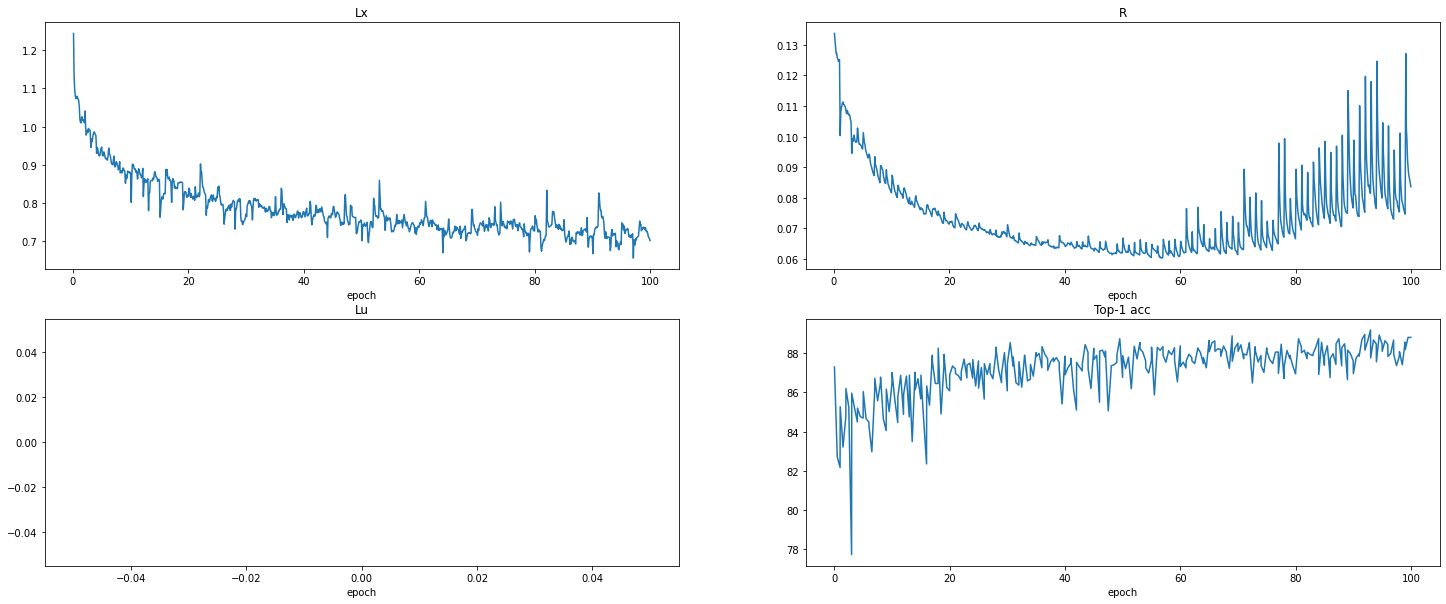

In [22]:
train(labeled_trainloader, unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=True, exp_name='no_cbs')
plot_result(torch.load('runs/no_cbs.bin'))

In [23]:
# lambda_u_search
# for current_lambda_u in [2 , 5 , 10 , 15, 20, 30, 150]:
#     model.load_state_dict(torch.load(f"cifar10/clf_learning/final_model_wts.bin"))
#     train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name=f'reproduce_lu_{current_lambda_u}', epochs=7, lambda_u=current_lambda_u)